# Etapas
## Etapa 1: Calcular a probabilidade de pessoas sem diagnóstico terem a doença dado que elas pertencem a um determinado cluster
### Método elbow 
* Definir a quantidade ótima de clusters para o nosso conjunto de dados
* O PCA foi utilizado para diminuir a dimensão do espaço das fetures de 8 para 2. Dessa forma,  o método definirá a quantidade ideal de cluster em um espaço de duas dimensões.
* O PCA foi utilizado para obter uma representação melhor dos clusters no gráfico de duas dimensões
* A eficiência na divisão dos clusters é pouco afetada porque PCA mantém a essência dos dados originais

### Clusterização
* Realizar a clusterização utilizando o MinibatchKmean
* A quantidade de clusters será a definida pelo método elbow
* O PCA foi utilizado novamente para diminuir o espaço das features de 8 para 2. Portanto, a clusterização será baseada nas duas features geradas pelo PCA (pca1 e pca2).
* Não há problema implementar a clusterização dessa forma pois o PCA mantém o máximo possível da essência (diferenças entre as amostras) dos dados originais
#### Análise da clusterização
* É impresso uma análise das features mais frequentes e do percentual de pessoas com e sem diagnóstico em cada cluster
* Além disso é gerado um dataframe com as features mais frequentes em cada cluster. As linhas representam os clusters e as colunas as features.

### Divisão dos conjuntos de treino, validação e teste
* Gera um dataframe para cada um dos clusters
* Inicialmente, cada Dataframe possui as pessoas de um determinadado cluster e as features de cada uma delas
* Em seguida cada Dataframe será filtrado para obter outro Dataframe somente com as pessoas que não tem o diagnóstico
* Dessa forma, teremos cinco (número de clusters) dataframes após a filtragem:

    - O dataframe 1 contém pessoas que não possuem diagnóstico dentro do cluster 1
    - O dataframe 2 contém pessoas que não possuem diagnóstico dentro do cluster 2
    - O dataframe 3 contém pessoas que não possuem diagnóstico dentro do cluster 3
    - O dataframe 4 contém pessoas que não possuem diagnóstico dentro do cluster 4
    - O dataframe 5 contém pessoas que não possuem diagnóstico dentro do cluster 5

### Aplicação do modelo de Regressão Logística    
* Os cinco dataframes acima que são compostos somente por pessoas sem diagnóstico serão utilizados como conjunto de teste no modelo de Regressão logística. O funcionamento ocorrerá da seguinte maneira:
    - Para o teste 1, o modelo 1 será treinado e validado com todo o dataset menos as amostras do dataframe 1
    - Para o teste 2, o modelo 2 será treinado e validado com todo o dataset menos as amostras do dataframe 2
    - Para o teste 3, o modelo 3 será treinado e validado com todo o dataset menos as amostras do dataframe 3
    - Para o teste 4, o modelo 4 será treinado e validado com todo o dataset menos as amostras do dataframe 4
    - Para o teste 5, o modelo 5 será treinado e validado com todo o dataset menos as amostras do dataframe 5

#### Treinamento e Validação
* Serão treinados e validados cinco modelos de regressão logística. A validação terá as seguintes informações:
    - Média da AU-ROC
    - Média da acurácia
    - Média do F1-score

#### Aplicação do Relief em cada modelo
* O relief define quais features estão mais relacionadas com os labels (status do paciente)
* Foi gerada uma classificação das features para cada um dos modelos.

### Cálculo da probabilidade de ter a doença nos conjuntos de teste
* Cálculo da probabilidade das pessoas sem diagnóstico dos conjuntos de teste terem a doença
* O funcionamento ocorre da seguinte maneira:
    - O modelo 1 calcula a probabilidade das pessoas sem diagnóstico do conjunto de teste 1 (pessoas sem diagnóstico e que pertencem ao cluster 1)
    - O modelo 2 calcula a probabilidade das pessoas sem diagnóstico do conjunto de teste 2 (pessoas sem diagnóstico e que pertencem ao cluster 2)
    - O modelo 3 calcula a probabilidade das pessoas sem diagnóstico do conjunto de teste 3 (pessoas sem diagnóstico e que pertencem ao cluster 3)
    - O modelo 4 calcula a probabilidade das pessoas sem diagnóstico do conjunto de teste 4 (pessoas sem diagnóstico e que pertencem ao cluster 4)
    - O modelo 5 calcula a probabilidade das pessoas sem diagnóstico do conjunto de teste 5 (pessoas sem diagnóstico e que pertencem ao cluster 5)        

    Ao final é gerado um gráfico que mostra a distribuição de probabilidade das pessoas sem diagnóstico terem a doença  dado que elas pertencem a um determinado cluster

## Etapa 2: Calcular a probabilidade de um novo paciente pertencer a um determinado cluster
### Selecionar uma pessoa do grupo de maior risco
* Selecionar uma amostra aleatória do grupo de maior risco
* Essa amostra será utilizada como teste. Ou seja, é esperado que o novo modelo gerado consiga prever que essa amostra pertence ao grupo de maior risco
### Modelo de regressão logística
* Nessa etapa também foi utilizado um modelo de regressão logística
* A diferença está nos rótulos que o modelo receberá. Nessa caso, os rótulos serão os clusters a qual cada amostra pertence
* Portanto, utilizando as mesmas features o modelo será treinado para prever a qual cluster cada amostra pertence
#### Treino e Validação
* A pessoa selecionada do grupo de maior risco deve ser retirada dos conjuntos de treino e validação do modelo já que será utiliazado no final do processo para fins de teste
* Divisão 80/20 para os conjuntos de treino e validação
#### Teste
* Ao final o modelo é testado utilizando a amostra pertencente ao grupo de maior risco
* O modelo prevê a probabilidade da amostra pertencer a cada um dos clusters


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from numpy import unique
from numpy import where
import statistics
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import MiniBatchKMeans

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from random import seed

%matplotlib inline

# import category_encoders as ce
# import sweetviz as sv
import dtale
from pandas_profiling import ProfileReport

from scipy.stats import chisquare
from scipy.stats import chi2_contingency
import pingouin as pg

#conda install numpy seaborn matplotlib scikit-learn scipy -y
#conda install -c conda-forge imbalanced-learn -y
#conda install -c conda-forge pandas-profiling -y
#conda install dtale -c conda-forge -y
#pip install Flask -U --user
#pip install sweetviz
#conda install -c conda-forge pingouin
#conda install ipympl -c conda-forge

/home/lpo_albert/miniconda3/envs/hansys/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

/home/lpo_albert/miniconda3/envs/hansys/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning:

numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.

/home/lpo_albert/miniconda3/envs/hansys/lib/python3.9/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-f

In [2]:
seed(1)

In [3]:
# __Conexão com o dataset em CSV
# df_tuberculosis = pd.read_csv('dataset_paciente_atualizado.csv', sep=';')
# df_tuberculosis = pd.read_csv('maindb.csv', encoding="utf-8", sep = ';')
dataset_path = '../Dataset/datasetTB4.csv'
df_tuberculosis = pd.read_csv(dataset_path, sep=';')

In [4]:
df_tuberculosis

,racaCor,faixaEtaria,sexo,ESCOLARID,TIPOCUP,sitAtual,tipoCaso,FORMACLIN1,classif,descoberta,...,MENTAL,DROGADICAO,TABAGISMO,motMudEsquema,tipoTrat,idade,HISTOPATOL,resistencia,Status_Paciente,Status_Resistencia
0,Branco,20_29,M,De 4 a 7 anos,Outra,Cura,Novo,Pul,Pul,Elucidacao Diagn. em Internacao,...,N,N,N,NaN,Supervisionado,23_39,N/realiz,SENS,Sem troca,1
1,Pardo,40_49,M,De 4 a 7 anos,Desempregado,Cura,Novo,Pul,P+E,Demanda Ambulatorial,...,N,N,S,NaN,Supervisionado,40_54,N/realiz,SENS,Sem troca,1
2,Pardo,40_49,M,De 8 a 11 anos,Outra,Cura,Novo,Pul,P+E,Elucidacao Diagn. em Internacao,...,N,N,N,NaN,Auto-Administrado,40_54,BAAR pos,SENS,Sem troca,1
3,Branco,50_59,M,De 4 a 7 anos,Outra,Cura,Novo,Pul,P+E,Demanda Ambulatorial,...,N,N,N,NaN,Supervisionado,Mais de 54,N/realiz,SENS,Sem troca,1
4,Branco,30_39,M,De 4 a 7 anos,Outra,Cura,Novo,Pul,P+E,Urgencia / Emergencia,...,N,S,N,NaN,Supervisionado,23_39,Sugestivo TB,NaN,Sem troca,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,Indigena,50_59,M,De 4 a 7 anos,Outra,Cura,Novo,Pul,Pul,Demanda Ambulatorial,...,N,N,N,NaN,Supervisionado,Mais de 54,N/realiz,SENS,Sem troca,1
1532,Preto,01_04,M,Nenhuma,Outra,Cura,Novo,Meningea,Ext,Urgencia / Emergencia,...,N,N,N,NaN,Auto-Administrado,0_22,Sugestivo TB,NaN,Sem troca,0
1533,Pardo,30_39,M,De 8 a 11 anos,Outra,Cura,Recidiva,Pul,Pul,Elucidacao Diagn. em Internacao,...,N,N,N,NaN,Supervisionado,23_39,N/realiz,SENS,Sem troca,0
1534,Pardo,30_39,M,De 1 a 3 anos,Desempregado,Cura,Novo,Pul,Pul,Elucidacao Diagn. em Internacao,...,N,S,N,NaN,Supervisionado,23_39,N/realiz,SENS,Sem troca,1


In [5]:
try:
    df_tuberculosis = df_tuberculosis.drop('testesensibilidade', axis=1)
except:
    pass

In [6]:
# Exclui a primeira coluna do dataframe
# O dataset está com a primeira coluna sem nome. Os valores representam o índice na excel
# Não precisamos dessa coluna
try:
    if df_tuberculosis.columns[0] == "Unnamed: 0":
        df_tuberculosis = df_tuberculosis.iloc[:, 1:]  # Exclui a primeira coluna do dataframe
except IndexError:
    pass

In [7]:
df_tuberculosis.head(3)

,racaCor,faixaEtaria,sexo,ESCOLARID,TIPOCUP,sitAtual,tipoCaso,FORMACLIN1,classif,descoberta,...,MENTAL,DROGADICAO,TABAGISMO,motMudEsquema,tipoTrat,idade,HISTOPATOL,resistencia,Status_Paciente,Status_Resistencia
0,Branco,20_29,M,De 4 a 7 anos,Outra,Cura,Novo,Pul,Pul,Elucidacao Diagn. em Internacao,...,N,N,N,NaN,Supervisionado,23_39,N/realiz,SENS,Sem troca,1
1,Pardo,40_49,M,De 4 a 7 anos,Desempregado,Cura,Novo,Pul,P+E,Demanda Ambulatorial,...,N,N,S,NaN,Supervisionado,40_54,N/realiz,SENS,Sem troca,1
2,Pardo,40_49,M,De 8 a 11 anos,Outra,Cura,Novo,Pul,P+E,Elucidacao Diagn. em Internacao,...,N,N,N,NaN,Auto-Administrado,40_54,BAAR pos,SENS,Sem troca,1


In [8]:
try:
    df_tuberculosis = df_tuberculosis.drop(['Status_Paciente', 'resistencia'], axis=1)
except:
    pass

In [9]:
# Analisa os dados utlizando o pandas profiling
report = ProfileReport(df_tuberculosis,  minimal=True, title='Tuberculosis Analysis')

In [10]:
# Salva o arquivo html com as análises realizadas pelo pandas profiling
report.to_file("../EDA/tuberculosis_analysis.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 1174.55it/s]


In [11]:
# Gestante tem que ser retirada.
# ESCOLAR está correto? Não deveria ser o grau de escolaridade? 
# codTratAnt, o que significa? Os valores são inteiros de 1 a 9, porém, 91% são do tipo 1, ou seja, está desbalanceada.
# tratouha é 98% do tipo 0. Está desbalanceada. Não podemos usar.
# FORMACLIN2 está com 91% de valores nulos. Não vamos usar.
# FORMACLIN3 está com 99% de valores nulos. Não vamos usar.
# RXOUTRO está com muitos valores nulos e desbalanceada. Não sabemos acrescenta muito na análise. Não vamos usar.
# NECROP é 99% do tipo N/realiz. Ou seja, está desbalanceada e não comtribui para a análise. Não vamos usar.
# COMUNICEXA possui valores de 0 a 9 mas, 43.2% são igual a 0. Não vamos usar.
# COMUNICDOE possui valores de 0 a 9 mas, 43.2% são igual a 0. Não vamos usar.
# instTrat é uma variável sobre a instituição de tratamento. Não vamos usar.
# esqAtual está com 51% de valores nulos e 40% de valores iguais a OUTROS. Não vamos usar.
# nDosesPri desbalanceada e com valores nulos
# nDosesSeg desbalanceada e com valores nulos
# mtvInter1 66% de valores nulos
# OUTRAIMUNO está desbalanceada com 98% dos valores igual a N.
# resistencia 78% são valores nulos

In [12]:
# Alerta
# CULOUTRO está com muitos valores nulos e desbalanceada. Não sabemos acrescenta muito na análise.
# BACOUTRO está com muitos valores nulos e desbalanceada. Não sabemos acrescenta muito na análise.
# testesensibilidade 88% são valores nulos
# HISTOPATOL está com 16% de valores nulos e desbalanceada com 70% do tipo N/realiz.
# mtvInter1 é importante mas está com 66% de valores nulos

In [13]:
# # Mostra a análise realizada pelo d-tale
# analize_dtale

In [14]:
# # Realiza a analise do dataset utlizando a biblioteca sweetviz
# analyze_report = sv.analyze(df_tuberculosis)

In [15]:
# # Abre o arquivo html no navegador com as análises que foram realizadas pelo swetviz
# analyze_report.show_html('analize.html')

* Remove o mdEsquema e motMudEsquema pois são variáveis redundantes em relação ao status do paciente

In [16]:
# df_tuberculosis = df_tuberculosis.drop(['mdEsquema', 'motMudEsquema' ], axis=1)

## Qui-quadrado

* Qui-quadrado

In [17]:
# # Calculo do qui-quadrado em relação à variável de status do paciente

# # Armazena os valores de qui-quadrado e valor de p
# all_pvalue = pd.DataFrame()

# # Pandas index com os nomes das colunas
# feature_names = df_tuberculosis.columns
# # Converte para lista
# feature_names = list(feature_names)
# # Exclui a coluna de Status de paciente e os tipos de pacientes
# feature_names.remove('Status_Resistencia')

# # Realiza qui-quadrado para cara feature
# for i in feature_names:
#     # Cria um dataframe com duas colunas: feature i e Status_Resistencia
#     df_chisquare = df_tuberculosis.loc[:,[i, 'Status_Resistencia']].dropna()

#     df_chisquare = df_chisquare.query(f'{i} not in ["Não Preenchido", "Duvidosa"]')

#     # # Obtem somente as amostras significativas, ou seja, exclui amostras como "Não realizado", "Duvidosa", etc.
#     # if i in ["GRAU_DE_INCAPACIDADE_FISICA"]:
#     #     df_chisquare = df_chisquare.query(f'{i}=="0" or {i}=="1"')

#     # # Obtem somente as amostras significativas, ou seja, exclui amostras como "Não realizado", "Duvidosa", etc.
#     # if i == "BACILOSCOPIA":
#     #     df_chisquare = df_chisquare.query(f'{i}=="Positiva" or {i}=="Negativa"')

#     # # Obtem somente as amostras significativas
#     # if i == "GRAU_ESCOLAR":
#     #     df_chisquare = df_chisquare.query(f'{i}=="Ensino Fundamental" or {i}=="Ensino Médio" or {i}=="Ensino Superior"')

#     # # Obtem somente as amostras significativas
#     # if i == "CONTATO_PERIODO":
#     #     df_chisquare = df_chisquare.query(f'{i}=="Mais que dez anos" or {i}=="Entre cinco a dez anos" or {i}=="Entre dois a cinco anos" or {i}=="Mais que um ano" or {i}=="Entre um a dois anos"')
    
#     # Cria a tabela de contingência
#     contingency_table = pd.crosstab(df_chisquare[i], df_chisquare['Status_Resistencia'])
    
#     # Calcula o qui-quadrado
#     expected, observed, stats = pg.chi2_independence(df_chisquare, x=i, y='Status_Resistencia')
#     # Adiciona o nome da feature no dataset com os valores do qui-quadrado para fins de identificação
#     stats['Feature'] = i
    
#     # Seleciona apenas o qui-quadrado de pearson 
#     stats = stats.query('test=="pearson"')

#     # Adiciona ao dataframe com o qui-quadrado de todas as features
#     all_pvalue = pd.concat([stats, all_pvalue])

In [18]:
# # Mostra somente as features com valores de p<0.05 
# all_pvalue.query('pval<=0.05').sort_values(by='pval', ascending=False)

## One-hot Encode

In [19]:
# Transformando variáveis categoricas em númericas
df_dummy = pd.get_dummies(df_tuberculosis)

In [20]:
df_dummy.head(3)

,Status_Resistencia,racaCor_Amarelo,racaCor_Branco,racaCor_Indigena,racaCor_Pardo,racaCor_Preto,faixaEtaria_01_04,faixaEtaria_05_09,faixaEtaria_10_14,faixaEtaria_15_19,...,motMudEsquema_Resistencia Medicamentosa,tipoTrat_Auto-Administrado,tipoTrat_Supervisionado,idade_0_22,idade_23_39,idade_40_54,idade_Mais de 54,HISTOPATOL_BAAR pos,HISTOPATOL_N/realiz,HISTOPATOL_Sugestivo TB
0,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0


* Retira as colunas dos valores não preenchidos

In [21]:
# Substituir NaN por 0
df_tuberculosis.fillna('Nulo', inplace=True)
df_tuberculosis.head(3)

,racaCor,faixaEtaria,sexo,ESCOLARID,TIPOCUP,sitAtual,tipoCaso,FORMACLIN1,classif,descoberta,...,DIABETES,ALCOOLISMO,MENTAL,DROGADICAO,TABAGISMO,motMudEsquema,tipoTrat,idade,HISTOPATOL,Status_Resistencia
0,Branco,20_29,M,De 4 a 7 anos,Outra,Cura,Novo,Pul,Pul,Elucidacao Diagn. em Internacao,...,N,N,N,N,N,Nulo,Supervisionado,23_39,N/realiz,1
1,Pardo,40_49,M,De 4 a 7 anos,Desempregado,Cura,Novo,Pul,P+E,Demanda Ambulatorial,...,N,S,N,N,S,Nulo,Supervisionado,40_54,N/realiz,1
2,Pardo,40_49,M,De 8 a 11 anos,Outra,Cura,Novo,Pul,P+E,Elucidacao Diagn. em Internacao,...,N,N,N,N,N,Nulo,Auto-Administrado,40_54,BAAR pos,1


In [22]:
# Pandas index com os nomes das colunas
feature_names = df_dummy.columns
feature_names

for i in range(len(feature_names)):
    if "Nulo" in feature_names[i]:
        df_dummy = df_dummy.drop(f"{feature_names[i]}", axis=1) 

In [23]:
df_dummy.head(3)

,Status_Resistencia,racaCor_Amarelo,racaCor_Branco,racaCor_Indigena,racaCor_Pardo,racaCor_Preto,faixaEtaria_01_04,faixaEtaria_05_09,faixaEtaria_10_14,faixaEtaria_15_19,...,motMudEsquema_Resistencia Medicamentosa,tipoTrat_Auto-Administrado,tipoTrat_Supervisionado,idade_0_22,idade_23_39,idade_40_54,idade_Mais de 54,HISTOPATOL_BAAR pos,HISTOPATOL_N/realiz,HISTOPATOL_Sugestivo TB
0,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0


In [24]:
df_varSelecionadas = df_dummy
# df_varSelecionadas.columns

In [25]:
df_varSelecionadas.head()
#pd.set_option("max_rows", None)

,Status_Resistencia,racaCor_Amarelo,racaCor_Branco,racaCor_Indigena,racaCor_Pardo,racaCor_Preto,faixaEtaria_01_04,faixaEtaria_05_09,faixaEtaria_10_14,faixaEtaria_15_19,...,motMudEsquema_Resistencia Medicamentosa,tipoTrat_Auto-Administrado,tipoTrat_Supervisionado,idade_0_22,idade_23_39,idade_40_54,idade_Mais de 54,HISTOPATOL_BAAR pos,HISTOPATOL_N/realiz,HISTOPATOL_Sugestivo TB
0,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1


## Pre-processsamento dos Dados

In [26]:
# # Codifica as variáveis para números

# # Identificar as colunas do tipo 'object'
# colunas_object = df_tuberculosis.select_dtypes(include=['object']).columns

# # Criar um dicionário para armazenar o mapeamento de cada coluna
# mapeamento = {}

# # Iterar sobre as colunas e fazer a categorização
# for coluna in colunas_object:
#     categorias = df_tuberculosis[coluna].unique()
#     mapeamento[coluna] = {valor: index for index, valor in enumerate(categorias)}

#     # Categorizar a coluna
#     df_tuberculosis[coluna] = df_tuberculosis[coluna].map(mapeamento[coluna])

# # Exibir o mapeamento
# print(mapeamento)


In [27]:
# df_tuberculosis.head(3)

In [28]:
# # Função para decoficar os valores
# # Será útil na análise dos resultados

# def decodificar_valores(df, mapeamento):
#     df_decodificado = df.copy()  # Cria uma cópia do dataframe para evitar alterações indesejadas

#     for coluna, mapeamento_coluna in mapeamento.items():
#         df_decodificado[coluna] = df_decodificado[coluna].map({indice: valor for valor, indice in mapeamento_coluna.items()})

#     return df_decodificado

# df_tuberculosis_decode = decodificar_valores(df_tuberculosis, mapeamento)
# df_tuberculosis_decode.head(3)

In [29]:
# # Normalização utilizando o Z-Score

# df_tuberculosis_normalized = df_varSelecionadas.copy()  # Cria uma cópia do dataframe para evitar alterações indesejadas

# # Normalização Z-score para cada coluna
# for coluna in df_tuberculosis_normalized.columns[:-1]:
#     df_tuberculosis_normalized[coluna] = zscore(df_tuberculosis_normalized[coluna])

# # Exibir o dataframe normalizado
# display(df_tuberculosis_normalized.head(3))

In [30]:
df_tuberculosis_normalized = df_varSelecionadas.copy()  # Cria uma cópia do dataframe para evitar alterações indesejadas

# Normalização Min-Max para cada coluna
scaler = MinMaxScaler()
df_tuberculosis_normalized[df_tuberculosis_normalized.columns[:-1]] = scaler.fit_transform(df_tuberculosis_normalized[df_tuberculosis_normalized.columns[:-1]])

# Exibir o dataframe normalizado
display(df_tuberculosis_normalized.head(3))

,Status_Resistencia,racaCor_Amarelo,racaCor_Branco,racaCor_Indigena,racaCor_Pardo,racaCor_Preto,faixaEtaria_01_04,faixaEtaria_05_09,faixaEtaria_10_14,faixaEtaria_15_19,...,motMudEsquema_Resistencia Medicamentosa,tipoTrat_Auto-Administrado,tipoTrat_Supervisionado,idade_0_22,idade_23_39,idade_40_54,idade_Mais de 54,HISTOPATOL_BAAR pos,HISTOPATOL_N/realiz,HISTOPATOL_Sugestivo TB
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0


## Divisão de features e saídas

In [31]:
# Organizando os dataframes

# Retira a coluna Status do paciente já que essa feature será a saída (label)
features = df_tuberculosis_normalized.drop(['Status_Resistencia'], axis=1)

# Saída com o status dos pacientes será utilizada nos modelos preditivos
labels = df_tuberculosis_normalized['Status_Resistencia'].values

# Gera um dataframe onde será adicionada uma coluna ('Cluster') que indicará a qual cluster cada pessoa pertence
df_cluster = df_tuberculosis_normalized.copy()

In [32]:
df_cluster.head(3)

,Status_Resistencia,racaCor_Amarelo,racaCor_Branco,racaCor_Indigena,racaCor_Pardo,racaCor_Preto,faixaEtaria_01_04,faixaEtaria_05_09,faixaEtaria_10_14,faixaEtaria_15_19,...,motMudEsquema_Resistencia Medicamentosa,tipoTrat_Auto-Administrado,tipoTrat_Supervisionado,idade_0_22,idade_23_39,idade_40_54,idade_Mais de 54,HISTOPATOL_BAAR pos,HISTOPATOL_N/realiz,HISTOPATOL_Sugestivo TB
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0


## Funções

In [33]:
def show_status(frequencia):
    """
        Função para visualizar melhor as porcentagens de casos com e sem diagnóstico
        Retorna duas variáveis com o percentual de casos positivos e o percentual de casos negativos
        Parâmetros:
            *frequência: lista com duas posições referentes aos percentuais de cada status
    """

    if len(frequencia)>1:
        status_positivo = float(frequencia[0])
        status_negativo = float(frequencia[1])     
    else:
        status_positivo = 0
        status_negativo = float(frequencia[0])
    return status_positivo, status_negativo

In [34]:
def frequencia_status(df_cluster):
    """
    Retorna a frequência, em porcentagem, dos status (positivo ou negativo) dos pacientes dentro do cluster
    Parâmetros:
        * df_cluster: dataframe de um cluster, esse dataframe é gerado pela função build_cluster
    
    """
    # Frequência com que os valores de determinada coluna aparecem
    frequencia = df_cluster.groupby(['Status_Resistencia']).size()
        

    #Transforma de Pandas.Series para numpy array
    frequencia = np.asarray(frequencia)

    # Transformando numpy array para dataframe
    frequencia = pd.DataFrame(frequencia, columns=['Status_Resistencia'])
    status = frequencia.index.tolist()

    # Calcula o percentual
    frequencia['Status_Resistencia'] = (frequencia['Status_Resistencia'] / frequencia['Status_Resistencia'].sum()) * 100

    # Transforma de dataframe para numpy array
    frequencia = np.asarray(frequencia)

    return frequencia, status

In [35]:
def build_cluster (index_cluster, df_cluster):

    """
    Retorna um dataframe apenas com os pacientes do cluster em questão.
    Parâmetros:
        * index_cluster: indíce do cluster gerado pelo algoritmo de clusterização
        * df_cluster: dataframe com as colunas das features mais a coluna de clusters
    
    """
    # lista com o índice do cluster (o método .isn aceita apenas listas)
    indice = [index_cluster]
    # Filtro que gera um novo dataframe apenas com as pessoas do cluster 
    cluster = df_cluster[df_cluster['Cluster'].isin(indice)]

    return cluster 


In [36]:
def plotar_cluster(cluster, df_cluster):
    """
        Plot dos clusters. Diferencia as pessoas por clusters e por diagnóstico
        Parâmetros:
            * df_cluster: Dataframe do algoritmo de clusterização. 
              Esse dataframe é uma cópia do dataframe original, porém, a coluna cluster (que indica a qual cluster cada pessoa pertence)
               está preechida de acordo com o algoritmo de clusterização utilizado. 

    """
    # importa PCA
    from sklearn.decomposition import PCA
    from prince import MCA

    new_column = {'Status_Resistencia': 'Patient Status'}
    
    df_cluster = df_cluster.rename(columns=new_column)

    df_cluster = df_cluster.copy()

    # Executa o PCA e reduz a dimensão para o valor especificado em n_components
    # Nesse caso n_components = 2, ou seja, os dados serão reduzidos para duas dimensões
    reduced_data = MCA(n_components=2).fit_transform(df_cluster)

    names = ['mca1', 'mca2']
    # Dataframe com os dados em duas dimesões
    # results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
    results = reduced_data.copy()
    results.columns = names

    # Adicionando colunas com os valores de PCA no dataframe do cluster
    df_cluster['mca1'] = results['mca1']
    df_cluster['mca2'] = results['mca2']

    # Gera figura (fig) e região de plotagem (ax), definindo largura, altura e layout
    fig, ax = plt.subplots(figsize=(12, 6), layout="constrained")

    Status_Resistencia_unique = pd.unique(df_cluster['Patient Status'])
    Status_Resistencia_unique = np.sort(Status_Resistencia_unique)
    
    # Estilo de marcadores para os status
    markers = {Status_Resistencia_unique[0]: "o", Status_Resistencia_unique[1]: "X"}
    
    # Plot do gráfico
    # hue: qual coluna do dataframe está sendo plotada
    # size: quantos tamanhos diferentes queremos, nesse caso vão ser n tamanhos diferentes sendo n o número de clusters
    # sizes: valor do primeiro tamanho e valor do ultimo tamanho. Os tamanhos intermediários  são valores igualmente espaçados
    # data: dados utilizados para plotar
    # ax: indica a região de plotagem
    # Style: define quantos estilos os marcadores vão ter
    # markers: indica o estilo dos marcadores

    # , size=df_cluster['Cluster'], sizes=(50,250)
    grafico = sns.scatterplot(x="mca1", y="mca2", hue=df_cluster['Cluster'], palette="Accent", s = 200, data=df_cluster, 
    ax=ax, style="Patient Status", markers=markers)

    # Para mais paleta de cores: https://seaborn.pydata.org/tutorial/color_palettes.html

    # Legenda fora do plot principal
    grafico.legend(bbox_to_anchor= (1,1), fontsize = 12)
    # Titulo do gráfico
    pyplot.title('Clustering with 2 dimensions')
    pyplot.show()


In [37]:
def frequencia(df_cluster):

    """
        Retorna o primeiro e o segundo valor mais frequente da feature
        * df_cluster: é apenas uma coluna do dataframe, por exemplo, df['Forma Clinica']
    """
    
    # Importa o Counter que será utilizado para obter a frequência dos valores da feature
    from collections import Counter
    
    # Cria uma lista a partir dos valores da coluna
    lista = df_cluster.tolist()
    # Obtem a frequencia de cada um dos valores da lista
    frequencia = Counter(lista).most_common()

    if len(frequencia)>1:
        # armazena o primeiro e o segundo valor mais frequente na lista
        mais_frequente, segundo_mais_frequente = frequencia[0], frequencia[1]
    elif len(frequencia)==1:
        # Caso não haja um segundo valor mais frequente
        mais_frequente, segundo_mais_frequente = frequencia[0], (None, None)
    else:
        mais_frequente, segundo_mais_frequente = (None, None), (None, None)

    return mais_frequente, segundo_mais_frequente

In [38]:
def cluster_analysis(quantidade_clusters, df_cluster):

    print('ANÁLISE DOS CLUSTERS:\n')
    # print('-'*50)

    #lista que armazena o tamanho de cada um dos clusters
    tamanho_clusters = []
    # Dicionário com todos os clusters. A chave corresponde ao índice  do cluster e o valor é o dataframe com as pessoas desse cluster
    dict_cluster = {}
        
    # Cada valor de i representa o índice de um cluster
    for i in range(quantidade_clusters):
        
        # Dataframe somente com as pessoas do cluster
        cluster = build_cluster(i, df_cluster)
        # Adiciona o cluster ao dicionário
        dict_cluster[i] = cluster
        # Obtem o tamanhado do cluster
        tamanho_cluster1 = cluster.shape[0]
        # Adiciona o tamanho do cluster na lista de tamanhos
        tamanho_clusters.append(tamanho_cluster1)
        # Mostra o tamanho do cluster
        print(f'Cluster {i}: {cluster.shape[0]} amostras')




    # Nome das features em uma lista
    features_names = list(df_cluster.columns)

    # Dicionário para armazer listas com os valores mais frequentes das features para cada cluster
    dict_features = {}
    # Percorre o número de features
    for i in range(len(features_names)):
        # Adiciona a lista ao dicionário
        feature_values = []
        dict_features[i] = feature_values



    print('\n')
    print('FEATURES DOS CLUSTERS:')

    # Percorre os clusters
    ## Cada valor de i representa o índice de um cluster
    for i in range(quantidade_clusters):
        print('-'*50)
        print(f'CLUSTER {i} ({tamanho_clusters[i]}): \n')

        # A partir do dicionário indica o cluster que será utilizado
        cluster = dict_cluster[i]

        # Percorre todos os nomes das features do dataframe do cluster
        for feature in features_names:

             # Tupla com o primeiro e segundo valor mais fequente da feature
            # A tupla tem a forma: (Valor, Quantas vezez apareceu)
            mais_frequente, segundo_mais_frequente = frequencia(cluster[feature])
            
            # Índice do nome da feature
            index_feature = features_names.index(feature)
            # Obtem a lista a partir do dicionário
            list_feature = dict_features[index_feature]
            # Adiciona o valor mais fequente na lista da feature
            list_feature.append(mais_frequente[0])
            
            # A saida para os status deve ter uma formatação diferente
            if feature.strip().upper() == 'Status_Resistencia':

                # Quantos casos com e sem diagnóstico existem no cluster
                cluster_frequencia_status, indices_status = frequencia_status(cluster)
                
                try:
                    quantidade_diagnostico_positivo = cluster_frequencia_status[1]
                    quantidade_sem_diagnostico = cluster_frequencia_status[0]
                    # Indice 0 representa o status 1 que tem a doença
                    print(f'\nDiagnóstico Positivo: {quantidade_diagnostico_positivo[0]:.2f}%')
                    # Indice 1 representa o status 2 que não tem diagnóstico
                    print(f'Sem diagnóstico: {quantidade_sem_diagnostico[0]:.2f}%\n')
            
                except:
                    # Caso as pessoas do cluster só tenham um tipo de status
                    if len(indices_status)<=1:
                        # Caso todos sejam do status tipo 1 (tem o diagnóstico)
                        if indices_status[0] == 0:
                            quantidade_diagnostico_positivo = cluster_frequencia_status[0]
                            quantidade_sem_diagnostico = 0
                            # Indice 0 representa o status 1 que tem a doença
                            print(f'\nDiagnóstico Positivo: {quantidade_diagnostico_positivo[0]:.2f}%')
                            # Indice 1 representa o status 2 que não tem diagnóstico
                            print(f'Sem diagnóstico: {quantidade_sem_diagnostico:.2f}%\n')

                        # Caso todos sejam do status tipo 2 (não tem o diagnóstico)
                        if indices_status[0] == 1:
                            quantidade_diagnostico_positivo = 0
                            quantidade_sem_diagnostico = cluster_frequencia_status[0]
                            # Indice 0 representa o status 1 que tem a doença
                            print(f'\nDiagnóstico Positivo: {quantidade_diagnostico_positivo:.2f}%')
                            # Indice 1 representa o status 2 que não tem diagnóstico
                            print(f'Sem diagnóstico: {quantidade_sem_diagnostico[0]:.2f}%\n')


            # A feature cluster não será mostrada na tela
            elif feature.strip().upper() == 'CLUSTER':
                pass

            # Formatação para as outras features
            else:
                print(f'{feature} (Moda): [{mais_frequente[0]}]')
                print(f'    Nº {mais_frequente[0]}: {mais_frequente[1]} vezes')
                print(f'    Nº {segundo_mais_frequente[0]}: {segundo_mais_frequente[1]} vezes')


    # Lista para definir nomes para os clusters
    cluster_names = []
    for i in range(quantidade_clusters):
        cluster_names.append(f'Cluster {i+1}')

    # Dataframa para analisar os clusters
    df_groups = pd.DataFrame()

    for feature in features_names:
        # Índice do nome da feature
        index_feature = features_names.index(feature)
        # Obtem a lista a partir do dicionário
        list_feature = dict_features[index_feature]
        # Adiciona a lista nome e valores da feature para os n clusters sendo n o número de clusters
        df_groups[feature] = list_feature
    
    df_groups['Cluster'] = cluster_names

    df_groups = df_groups.set_index('Cluster')

    return df_groups

In [39]:
def cluster_analysis_sem_diagnostico(quantidade_clusters, df_cluster):

    print('ANÁLISE DOS CLUSTERS SOMENTE DAS PESSOAS SEM DIAGNÓSTICO:\n')
    # print('-'*50)

    # Nome das features em uma lista
    features_names = list(df_cluster.columns)

    #lista que armazena o tamanho de cada um dos clusters
    tamanho_clusters = []
    # Dicionário com todos os clusters. A chave corresponde ao índice  do cluster e o valor é o dataframe com as pessoas desse cluster
    dict_cluster = {}
        
    # Cada valor de i representa o índice de um cluster
    for i in range(quantidade_clusters):
        
        # Dataframe somente com as pessoas do cluster
        cluster = build_cluster(i, df_cluster)

        if len(cluster) == 0:
            # Caso o cluster não possua pessoas sem diagnóstico devemos gerar um dataframe vazio
            cluster = pd.DataFrame(columns=features_names)
            for feature in features_names:
                cluster[feature] = 0
        
        # Adiciona o cluster ao dicionário
        dict_cluster[i] = cluster
        
        # Obtem o tamanhado do cluster
        tamanho_cluster1 = cluster.shape[0]
        # Adiciona o tamanho do cluster na lista de tamanhos
        tamanho_clusters.append(tamanho_cluster1)
        # Mostra o tamanho do cluster
        print(f'Cluster {i}: {cluster.shape[0]} amostras')
        

    # Dicionário para armazer listas com os valores mais frequentes das features para cada cluster
    dict_features = {}
    # Percorre o número de features
    for i in range(len(features_names)):
        # Adiciona a lista ao dicionário
        feature_values = []
        dict_features[i] = feature_values



    # print('\n')
    # print('FEATURES DOS CLUSTERS:')

    # Percorre os clusters
    ## Cada valor de i representa o índice de um cluster
    for i in range(quantidade_clusters):
        # print('-'*50)
        # print(f'CLUSTER {i} ({tamanho_clusters[i]}): \n')

        # A partir do dicionário indica o cluster que será utilizado
        cluster = dict_cluster[i]
        
        
        # Percorre todos os nomes das features do dataframe do cluster
        for feature in features_names:

            if len(cluster)==0:
                mais_frequente, segundo_mais_frequente = (None, None), (None, None)
            else:
                 # Tupla com o primeiro e segundo valor mais fequente da feature
                # A tupla tem a forma: (Valor, Quantas vezez apareceu)
                mais_frequente, segundo_mais_frequente = frequencia(cluster[feature])

            # Índice do nome da feature
            index_feature = features_names.index(feature)
            # Obtem a lista a partir do dicionário
            list_feature = dict_features[index_feature]
            # Adiciona o valor mais fequente na lista da feature
            list_feature.append(mais_frequente[0])
            # A saida para os status deve ter uma formatação diferente
            if feature.strip().upper() == 'Status_Resistencia':
                pass

                # if len(cluster)==0:
                #     cluster_frequencia_status, indices_status = (None, None), (None, None)
                # else:
                #     # Quantos casos com e sem diagnóstico existem no cluster
                #     cluster_frequencia_status, indices_status = frequencia_status(cluster)
                # try:
                #     quantidade_diagnostico_positivo = cluster_frequencia_status[0]
                #     quantidade_sem_diagnostico = cluster_frequencia_status[1]
                #     # Indice 0 representa o status 1 que tem a doença
                #     print(f'\nDiagnóstico Positivo: {quantidade_diagnostico_positivo[0]:.2f}%')
                #     # Indice 1 representa o status 2 que não tem diagnóstico
                #     print(f'Sem diagnóstico: {quantidade_sem_diagnostico[0]:.2f}%\n')
                # except:
                #     # Caso as pessoas do cluster só tenham um tipo de status
                #     if len(indices_status)<=1:
                #         # Caso todos sejam do status tipo 1 (tem o diagnóstico)
                #         if indices_status[0] == 0:
                #             quantidade_diagnostico_positivo = cluster_frequencia_status[0]
                #             quantidade_sem_diagnostico = 0
                #             # Indice 0 representa o status 1 que tem a doença
                #             print(f'\nDiagnóstico Positivo: {quantidade_diagnostico_positivo[0]:.2f}%')
                #             # Indice 1 representa o status 2 que não tem diagnóstico
                #             print(f'Sem diagnóstico: {quantidade_sem_diagnostico:.2f}%\n')
                #         # Caso todos sejam do status tipo 2 (não tem o diagnóstico)
                #         if indices_status[0] == 1:
                #             quantidade_diagnostico_positivo = 0
                #             quantidade_sem_diagnostico = cluster_frequencia_status[0]
                #             # Indice 0 representa o status 1 que tem a doença
                #             print(f'\nDiagnóstico Positivo: {quantidade_diagnostico_positivo:.2f}%')
                #             # Indice 1 representa o status 2 que não tem diagnóstico
                #             print(f'Sem diagnóstico: {quantidade_sem_diagnostico[0]:.2f}%\n')

                #         if indices_status[0] == None:
                #             quantidade_diagnostico_positivo = None
                #             quantidade_sem_diagnostico = None
                #             # Indice 0 representa o status 1 que tem a doença
                #             print(f'\nDiagnóstico Positivo: {quantidade_diagnostico_positivo:.2f}%')
                #             # Indice 1 representa o status 2 que não tem diagnóstico
                #             print(f'Sem diagnóstico: {quantidade_sem_diagnostico[0]:.2f}%\n')

            # A feature cluster não será mostrada na tela
            elif feature.strip().upper() == 'CLUSTER':
                pass
            # Formatação para as outras features
            else:
                pass
                # print(f'{feature} (Moda): [{mais_frequente[0]}]')
                # print(f'    Nº {mais_frequente[0]}: {mais_frequente[1]} vezes')
                # print(f'    Nº {segundo_mais_frequente[0]}: {segundo_mais_frequente[1]} vezes')
            


    # Lista para definir nomes para os clusters
    cluster_names = []
    for i in range(quantidade_clusters):
        cluster_names.append(f'Cluster {i+1}')

    # Dataframa para analisar os clusters
    df_groups = pd.DataFrame()

    for feature in features_names:
        # Índice do nome da feature
        index_feature = features_names.index(feature)
        # Obtem a lista a partir do dicionário
        list_feature = dict_features[index_feature]
        # Adiciona a lista nome e valores da feature para os n clusters sendo n o número de clusters
        df_groups[feature] = list_feature
    
    df_groups['Cluster'] = cluster_names

    df_groups = df_groups.set_index('Cluster')

    return df_groups

In [40]:
def get_df_train_test (index_cluster, df_cluster):

    """
    Retorna um dataframe (df_train) que será utilizado para gerar um conjunto de treino e um dataframe (df_sem_diagnóstico) que será utilizado para gerar conjunto de teste
    Parâmetros:
        * index_cluster: indíce do cluster gerado pelo algoritmo de clusterização
        * df_cluster: dataframe com as colunas das features mais a coluna de clusters

    O conjunto de teste será formado pelas pessoas que não tem diagnóstico dentro do cluster indicado
    O conjunto de treino serão todas as outras pessoas
    """
    # lista com o índice do cluster (o método .isn aceita apenas listas)
    indice = [index_cluster]
    # Filtro que gera um novo dataframe apenas com as pessoas do cluster indicado
    cluster = df_cluster[df_cluster['Cluster'].isin(indice)]

    # lista com o valor que representa pessoas sem diagnostico (o método .isn aceita apenas listas)
    indice_sem_diagnostico = [0] # Pessoas sem diagnóstico possuem status 2

    # Dataframe com as pessoas do cluster que não tem diagnóstico
    df_sem_diagnostico = cluster[cluster['Status_Resistencia'].isin(indice_sem_diagnostico)]

    # tamanho do dataframe com as pessoas sem diagnóstico
    tamanho_df_sem_diagnostico = df_sem_diagnostico.shape[0]
    # print(f'Tamanho do df_teste: {tamanho_df_sem_diagnostico}')

    # if tamanho_df_sem_diagnostico > 50:
    #     print(f'Dividindo o Dataframe de pessoas sem diagnóstico...')
    #     print(f'Tamanho antes: {tamanho_df_sem_diagnostico}')
    #     # Seleciona apenas metade das pessoas do dataframe
    #     # metade_do_df = int(tamanho_df_sem_diagnostico/2)
    #     df_sem_diagnostico = df_sem_diagnostico.iloc[:50,:]

    #     print(f'Tamanho depois: {df_sem_diagnostico.shape[0]}')

    # Pandas Series com os índices das amostras que não tem o diagnóstico
    indices_sem_diagnostico = df_sem_diagnostico.index

    # Dataframe com todas as pessoas exceto as pesssoas que não tem o diagnóstico no cluster indicado
    # Esse dataframe será utilizado para treinar o modelo
    # Utiliza os índices da etapa anterior para identificar as amostras
    df_train = df_cluster.drop(df_cluster.index[indices_sem_diagnostico])   

    return df_train, df_sem_diagnostico

In [41]:
def get_train_test(df_train, df_test):
    
    """
        Retorna os conjuntos de treino e teste
        Parâmetros:
            * df_train: dataframe de treino gerado pela função get_df_train_test
            * df_test: dataframe de teste gerado pela função get_df_train_test
    """

    X_train = df_train.drop(['Status_Resistencia', 'Cluster'], axis=1).values
    y_train = df_train['Status_Resistencia'].values

    X_test = df_test.drop(['Status_Resistencia', 'Cluster'], axis=1).values
    y_test = df_test['Status_Resistencia'].values

    # scaler = MinMaxScaler()
    # X_train = scaler.fit_transform(X_train)
    # if X_test.shape[0] != 0:
    #     X_test = scaler.fit_transform(X_test)

    # # Declara undersampler. Estratégia 0.2 significa que serão retiradas amostras da classe majoritária até a proporção ser de 0.33 (1 para 3)
    # under = RandomUnderSampler(sampling_strategy=0.5)
    # # Treina e retorna as amostras balanceadas
    # X_train, y_train = under.fit_resample(X_train, y_train)

    # O máximo de casos sem diagnóstico no dataset são 288
    # Se retirarmos mais de 200 amostras sem o diagnóstico, o treinamento com o restante das amostras será prejudicado
    # Dessa forma, precisamos balancear o os dados que serão utilizados no treinamento


    # if X_test.shape[0] > 100:
        
    # print('Balanceando algum conjunto de treino que esteja desbalanceado:')
    # Conta a frequência de cada valor de saida y_train antes do balanceamento
    # print(f'    Antes do balancemento: {Counter(y_train)}')
    # Declara undersampler.
    # under = RandomUnderSampler(sampling_strategy=0.5)
    # # Treina e retorna as amostras balanceadas
    # X_train, y_train = under.fit_resample(X_train, y_train)
    # Conta a frequência de cada valor de saida y_train depois do balanceamento
    # print(f'    Antes do balancemento: {Counter(y_train)}\n')



    return X_train, X_test, y_train, y_test

In [42]:
def get_cross_val (X_train, y_train, modeltype):
    from sklearn.preprocessing import StandardScaler
    # Divisão em conjunto de teste e validação
    # Essa divisão é necessária para validar o modelo
    # Somente após a validação é que o modelo será utilizado para prever a probabilidade no conjunto de teste (somente pessoas que não tem o diagnóstico)

    # scaler = StandardScaler()
    # scaler.fit(X_train)
    # X_train = scaler.transform(X_train)

    X_train_t, X_val, y_train_t, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # # Dimensionamento da base de treino
    # from sklearn.preprocessing import StandardScaler
    # scaler = StandardScaler()
    # scaler.fit(X_train)

    # X_train_t = scaler.transform(X_train_t)
    # X_val = scaler.transform(X_val)


    if modeltype == 'logmodel':
        # Treina o modelo de regressão logística
        model = LogisticRegression()

    if modeltype =='rfmodel':
        model = RandomForestClassifier()

    if modeltype == 'adaboost':
        model = AdaBoostClassifier(random_state=42)
    
    model.fit(X_train_t, y_train_t)

    # Preve no conjunto de validação
    pred_log = model.predict(X_val)

    # __Matriz de Confusão
    print(confusion_matrix(y_val, pred_log))
    print(classification_report(y_val, pred_log))

    matriz_confusão = confusion_matrix(y_val, pred_log)

    sns.heatmap(matriz_confusão, cmap='YlGnBu', annot=True, fmt='3')

    plt.title('Confusion Matrix')

    plt.ylabel('Real Values')
    plt.xlabel('Prediction Valeus')

    plt.show()

    # Com Cross Validação

    scores = cross_val_score(
        model, X_train, y_train, cv=10, scoring='roc_auc')
    mostrar_cross_val = np.mean(scores)
    print('[MODELO LOGISTIC REGRESSION] Média Roc-Auc dos 10 modelos com Cross Validação da base Treinamento:')
    print(f'Média ROC-AU: {mostrar_cross_val*100:.2f}% \n')

    scores = cross_val_score(
        model, X_train, y_train, cv=10, scoring='accuracy')
    mostrar_cross_val = np.mean(scores)
    print('[MODELO LOGISTIC REGRESSION] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:')
    print(f'Média Acurácia: {mostrar_cross_val*100:.2f}% \n')

    scores = cross_val_score(
        model, X_train, y_train, cv=10, scoring='f1')
    mostrar_cross_val = np.mean(scores)
    print('[MODELO LOGISTIC REGRESSION] Média de F1-Score dos 10 modelos com Cross Validação da base Treinamento:')
    print(f' Média F1-Score: {mostrar_cross_val*100:.2f}% \n')

    return model

In [43]:
def get_relief_score(X_train, y_train, features):
    # """
    #     Retorna um dataframe com os scores de cada feature

    # """

    # # Tipo do paciente não é utilizado no treinamento dos modelos.
    # features = features.drop(['Tipo do Paciente'], axis=1)
    
    # # Utilizando Relief para cada modelo gerado
    # numero_de_features = features.shape[1]
    # relief_multisurf = MultiSURF(n_features_to_select = numero_de_features)
    # relief_multisurf.fit(X_train, y_train)

    # multisurf_features = features.copy()
    # multisurf_score = relief_multisurf.feature_importances_

    # multisurf_values = pd.DataFrame(list(zip(
    # multisurf_features, multisurf_score)), columns=['Features', 'Score'])
    # multisurf_values = multisurf_values.sort_values(by='Score', ascending=False)

    # return multisurf_values

    return 0

In [44]:
def model_predict_proba(X_test, modelo):

    pred_proba = modelo.predict_proba(X_test) #predict_proba retorna a probabilidade de ser da classe zero e a probabilidade da classe 1
    pred_proba = pred_proba[:,0]  # Probabilidade de ter a doença (somente uma classe)

    pred_proba*=100

    return pred_proba


In [45]:
def calculate_wcss(data):
    wcss = []
    
    reduced_data = PCA(n_components=2).fit_transform(data)

    for n in range(2, 13):
        
        kmeans = MiniBatchKMeans(n_clusters=n, n_init=20, max_iter=100)
        kmeans.fit(X=reduced_data)
        wcss.append(kmeans.inertia_)

    return wcss

In [46]:
def optimal_number_of_clusters(wcss):
    x1, y1 = 1, wcss[0]
    x2, y2 = 9, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 1, distances


## Mini-Bach K-Means

* Define a quantidade ideal de clusters

In [47]:
df_cluster


,Status_Resistencia,racaCor_Amarelo,racaCor_Branco,racaCor_Indigena,racaCor_Pardo,racaCor_Preto,faixaEtaria_01_04,faixaEtaria_05_09,faixaEtaria_10_14,faixaEtaria_15_19,...,motMudEsquema_Resistencia Medicamentosa,tipoTrat_Auto-Administrado,tipoTrat_Supervisionado,idade_0_22,idade_23_39,idade_40_54,idade_Mais de 54,HISTOPATOL_BAAR pos,HISTOPATOL_N/realiz,HISTOPATOL_Sugestivo TB
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0
1532,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1533,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1534,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0


In [48]:
# from prince import MCA
# from kmodes.kmodes import KModes
# range_of_clusters = range(1, 10)
# wsse = []
# for k in range_of_clusters:
#     # reduced_data = PCA(n_components=2).fit_transform(df_cluster)
#     # minib_kmeans = MiniBatchKMeans(n_clusters=k, n_init=20, max_iter=100)

#     reduced_data = MCA(n_components=10).fit_transform(df_cluster)
#     minib_kmeans = KModes(n_clusters=k, n_init=20, max_iter=100, init='Huang')
    
#     minib_kmeans.fit(reduced_data)
#     # wsse.append(minib_kmeans.inertia_)
#     wsse.append(minib_kmeans.cost_)

    

In [49]:
# best_number_of_clusters, distances = optimal_number_of_clusters(wsse)
# print(f'A quantidade ideal de clusters é: {best_number_of_clusters}')
# distances

In [50]:
# # Valores do eixo x do gráfico
# x = range_of_clusters

# fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')
# param_dict = {'marker': 'o'}
# ax.plot(x, wsse,**param_dict, label='Sum of Squares')

# # Tamnho em pt dos eixos
# fonte_eixos = {'fontsize': 14}
# # Tamanho em pt do Título
# fonte_titulo = {'fontsize': 20}
# ax.set_xlabel('Number of Clusters', fontdict=fonte_eixos)
# ax.set_ylabel('Sum of Intra-Clusters Squares', fontdict=fonte_eixos)
# ax.set_xticks(np.arange(1, 10,1))
# # Adiciona um título para a região de plotagem (ax)
# ax.set_title("Elbow Method", fontdict=fonte_titulo)

# # Adiciona uma legenda para os rótulos dos gráficos serem exibidos
# ax.legend(fontsize = 14);

* Clusterização

In [51]:
# from kmodes.kmodes import KModes
# from prince import MCA
# import pandas as pd
# import matplotlib.pyplot as plt

# # Transformar as colunas categóricas em numéricas usando MCA
# mca = MCA(n_components=3)  # Definir o número de componentes principais desejado
# df_mca = mca.fit_transform(df_cluster)

# # Faixa de valores de clusters para testar
# max_clusters = 10
# inertia_values = []

# for n_clusters in range(1, max_clusters + 1):
#     km = KModes(n_clusters=n_clusters, init='Huang', n_init=10, random_state=2)
#     clusters = km.fit_predict(df_cluster)
#     inertia_values.append(km.cost_)

# # Plotar a curva de "elbow" para determinar o número ideal de clusters
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, max_clusters + 1), inertia_values, marker='o')
# plt.title('Método Elbow para Determinar Número Ideal de Clusters')
# plt.xlabel('Número de Clusters')
# plt.ylabel('Inércia')
# plt.show()

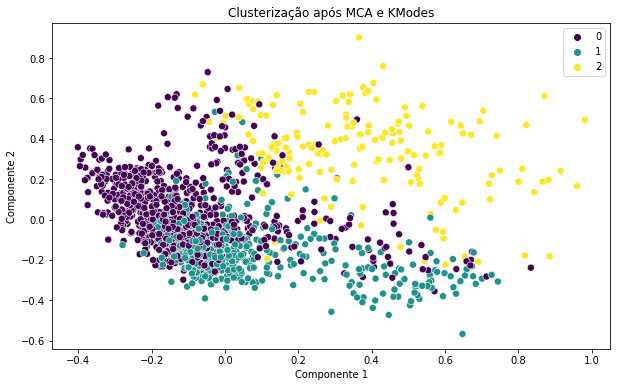

In [52]:
from kmodes.kmodes import KModes
from prince import MCA

# Transforme as colunas categóricas em numéricas usando MCA
mca = MCA(n_components=2)  # Defina o número de componentes principais desejado
df_mca = mca.fit_transform(df_cluster)

# Execute o KModes para clusterização
n_clusters = 3  # Número de clusters desejado
km = KModes(n_clusters=n_clusters, init='Huang', n_init=20, max_iter=100,random_state=2)
clusters_kmodes = km.fit_predict(df_cluster)  # Use o DataFrame original para o KModes

# Adicione o índice de cluster correspondente ao DataFrame após o MCA
df_kmodes = df_mca.copy()
mca_names = ['Componente 1', 'Componente 2']
df_kmodes.columns = mca_names
df_kmodes['Cluster'] = clusters_kmodes

# Função para visualização aprimorada dos clusters
def plotar_cluster_kmodes(df):
    plt.figure(figsize=(10, 6))

    # Escolha um mapa de cores de sua preferência
    colormap = 'viridis'

    # Plot dos clusters
    sns.scatterplot(data=df, x='Componente 1', y='Componente 2', hue='Cluster', palette=colormap, s=50)

    # Defina os rótulos dos eixos
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')

    # Defina o título do gráfico
    plt.title('Clusterização após MCA e KModes')

    # Mostrar a legenda
    plt.legend()

    # Mostrar o gráfico
    plt.show()

# Visualizar os clusters
plotar_cluster_kmodes(df_kmodes)


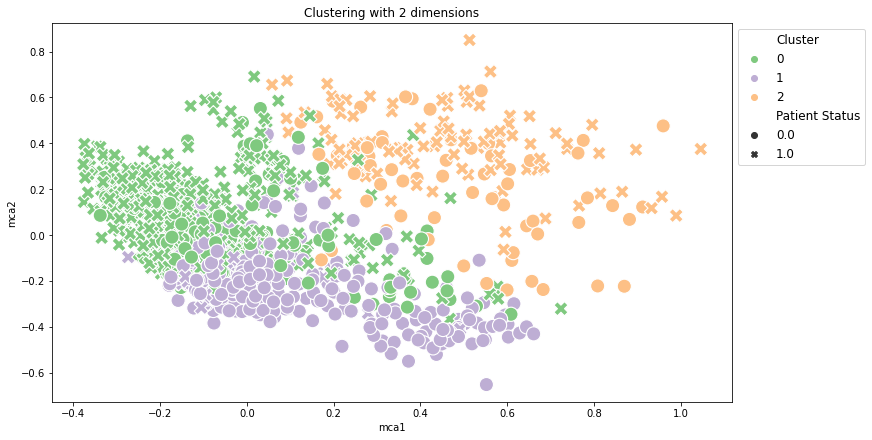

In [53]:
df_kmodes = df_cluster.copy()
df_kmodes['Cluster'] = clusters_kmodes
# Plotar gráfico dos clusters
plotar_cluster(clusters_kmodes, df_kmodes)

Número de clusters: 3
Índices dos clusters obtidos: [0 1 2]



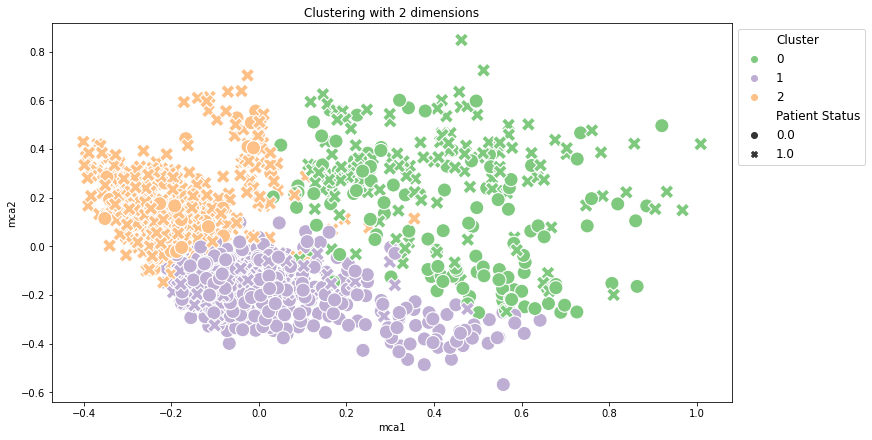

In [68]:
from sklearn.cluster import MiniBatchKMeans
# from kmodes.kmodes import KModes

# PCA para reduzir o espaço das features para duas dimensões
reduced_data = PCA(n_components=2, random_state=2).fit_transform(df_cluster)

# define the model
model = MiniBatchKMeans(n_clusters=3, n_init=10, max_iter=100, random_state=2)
# model = KModes(n_clusters=best_number_of_clusters, n_init=10, max_iter=100, random_state=2)

# fit the model
model.fit(reduced_data)
# assign a cluster to each example
clusters_minib_kmeans = model.predict(reduced_data)

# Copia o dataframe com os valores originais.
df_minib_kmeans = df_tuberculosis_normalized.copy()

# Adicionando o indice de cluster correspondendte na coluna Cluster
# A coluna Cluster indica a qual cluster cada pessoa pertence
df_minib_kmeans['Cluster'] = clusters_minib_kmeans


# array com os índices dos clusters
clusters = unique(clusters_minib_kmeans)
# Quantidade de clusters gerados
quantidade_clusters_minib = len(clusters)

print(f'Número de clusters: {quantidade_clusters_minib}')
print(f'Índices dos clusters obtidos: {clusters}\n')

# Plotar gráfico dos clusters
plotar_cluster(clusters_minib_kmeans, df_minib_kmeans)


In [69]:
# Adiciona a coluna de cluster no dataframe inicial (sem one hot encode)
df_tuberculosis['Cluster'] = df_minib_kmeans['Cluster']

In [70]:
# Adiciona a coluna de cluster no dataframe inicial (sem one hot encode)
df_tuberculosis['Cluster'] = df_kmodes['Cluster']

In [72]:
df_tuberculosis['sexo'].value_counts()

# Primeiro, converta a coluna para string
df_tuberculosis['sexo'] = df_tuberculosis['sexo'].astype(str)

# Em seguida, transforme em tipo categórico
df_tuberculosis['sexo'] = df_tuberculosis['sexo'].astype('category')

In [73]:
# Cria um dataframe para cada cluster por meio de um filtro na coluna cluster do dataframe principal (df_tuberculosis)
df_cluster1 = df_tuberculosis.query('Cluster==0')
df_cluster2 = df_tuberculosis.query('Cluster==1')
df_cluster3 = df_tuberculosis.query('Cluster==2')

In [74]:
# Cluster1_report = ProfileReport(df_cluster1, minimal=True, title="Cluster 1")
# Cluster2_report = ProfileReport(df_cluster2, minimal=True, title="Cluster 2")
# Cluster3_report = ProfileReport(df_cluster3, minimal=True, title="Cluster 3")

# Faz o relatório de cada cluster utlizando o ProfileReport
Cluster1_report = ProfileReport(df_cluster1, title="Cluster 1")
Cluster2_report = ProfileReport(df_cluster2, title="Cluster 2")
Cluster3_report = ProfileReport(df_cluster3, title="Cluster 3")

In [75]:
from pandas_profiling import ProfileReport, compare
comparison_report = compare([Cluster1_report, Cluster2_report, Cluster3_report])

# Save report to file
comparison_report.to_file("../EDA/Tuberculosis_Clusters_Comparison.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 231.03it/s]


## Classificador de Resistência Medicamentosa

In [76]:
df_tuberculosis['Cluster'] = df_minib_kmeans['Cluster']

In [77]:
# Inclui a coluna de clusters
df_tuberculosis_normalized['Cluster'] = df_tuberculosis['Cluster']
df_tuberculosis_normalized.head(3)

,Status_Resistencia,racaCor_Amarelo,racaCor_Branco,racaCor_Indigena,racaCor_Pardo,racaCor_Preto,faixaEtaria_01_04,faixaEtaria_05_09,faixaEtaria_10_14,faixaEtaria_15_19,...,tipoTrat_Auto-Administrado,tipoTrat_Supervisionado,idade_0_22,idade_23_39,idade_40_54,idade_Mais de 54,HISTOPATOL_BAAR pos,HISTOPATOL_N/realiz,HISTOPATOL_Sugestivo TB,Cluster
0,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0,2
1,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0,2
2,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0,0


In [78]:
# Cria um dataframe para cada cluster por meio de um filtro na coluna cluster do dataframe principal (df_tuberculosis)
df_cluster1_normalized = df_tuberculosis_normalized.query('Cluster==0')
df_cluster2_normalized = df_tuberculosis_normalized.query('Cluster==1')
df_cluster3_normalized = df_tuberculosis_normalized.query('Cluster==2')

In [79]:
# Forma o conjunto de teste a partir de amostras de cada um dos clusters

feature_cluster_1= df_cluster1_normalized.drop(['Status_Resistencia'], axis=1)
labels_cluster_1 =  df_cluster1_normalized['Status_Resistencia']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(feature_cluster_1, labels_cluster_1,test_size=0.1,stratify=labels_cluster_1, random_state=42)

feature_cluster_2= df_cluster2_normalized.drop(['Status_Resistencia'], axis=1)
labels_cluster_2 =  df_cluster2_normalized['Status_Resistencia']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(feature_cluster_2, labels_cluster_2,test_size=0.1,stratify=labels_cluster_2, random_state=42)

feature_cluster_3= df_cluster3_normalized.drop(['Status_Resistencia'], axis=1)
labels_cluster_3 =  df_cluster3_normalized['Status_Resistencia']
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(feature_cluster_3, labels_cluster_3,test_size=0.1,stratify=labels_cluster_3, random_state=42)

In [80]:
# Une as amostras de cada cluster

X_train = pd.concat([X_train_1, X_train_2, X_train_3], axis=0)
y_train = pd.concat([y_train_1, y_train_2, y_train_3], axis=0)

X_test = pd.concat([X_test_1, X_test_2, X_test_3], axis=0)
y_test = pd.concat([y_test_1, y_test_2, y_test_3], axis=0)

In [81]:
df_tuberculosis_normalized = df_tuberculosis_normalized.drop('Cluster', axis=1)

In [82]:
features = df_tuberculosis_normalized.drop('Status_Resistencia', axis=1)
labels = df_tuberculosis_normalized['Status_Resistencia']

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

### ReliefF

In [204]:
# from skrebate import ReliefF

# # Cria o objeto ReliefF
# relieff = ReliefF()

# # Aplica o ReliefF aos dados de treinamento e rótulos
# relieff.fit(X_train.values, y_train.values)

# # Obtém as pontuações de importância dos atributos
# importance_scores = relieff.feature_importances_

# # Cria um DataFrame com os atributos e suas pontuações de importância
# importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_scores})

# # Ordena o DataFrame em ordem decrescente de importância
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # Exibe o DataFrame ordenado
# print("Importance Scores:")
# print(importance_df)

Importance Scores:
                      Feature  Importance
68                cultEsc_Pos        0.42
66           cultEsc_N/realiz        0.27
67                cultEsc_Neg        0.04
91                TABAGISMO_S        0.04
90                TABAGISMO_N        0.04
..                        ...         ...
100          idade_Mais de 54       -0.00
9           faixaEtaria_20_29       -0.00
23   ESCOLARID_De 8 a 11 anos       -0.00
99                idade_40_54       -0.00
10          faixaEtaria_30_39       -0.01

[104 rows x 2 columns]


### Lazy Predictor
* Executa vários modelos

In [83]:
from lazypredict.Supervised import LazyClassifier, LazyRegressor

# Criar um LazyClassifier e treiná-lo com os dados de treino
clf = LazyClassifier()
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:04<00:00,  7.15it/s]

[LightGBM] [Info] Number of positive: 609, number of negative: 619
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 1228, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495928 -> initscore=-0.016287
[LightGBM] [Info] Start training from score -0.016287


In [84]:
# Exibir os resultados de cada modelo
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LinearDiscriminantAnalysis         0.79               0.79     0.79      0.79   
RidgeClassifierCV                  0.79               0.79     0.79      0.79   
RidgeClassifier                    0.79               0.79     0.79      0.79   
CalibratedClassifierCV             0.79               0.79     0.79      0.79   
LogisticRegression                 0.79               0.79     0.79      0.79   
LGBMClassifier                     0.79               0.79     0.79      0.79   
XGBClassifier                      0.79               0.79     0.79      0.79   
RandomForestClassifier             0.79               0.79     0.79      0.79   
SVC                                0.79               0.79     0.79      0.79   
ExtraTreesClassifier               0.78               0.78     0.78      0.78   
AdaBoostClassifier          

### Adaboost

[I 2023-08-25 12:16:51,452] A new study created in memory with name: no-name-d42b3261-f3bb-4076-b67c-465516dbb414
[I 2023-08-25 12:16:55,235] Trial 0 finished with value: 0.7980207916833267 and parameters: {'n_estimators': 132, 'learning_rate': 0.6726829641206514}. Best is trial 0 with value: 0.7980207916833267.
[I 2023-08-25 12:16:57,405] Trial 1 finished with value: 0.804578168732507 and parameters: {'n_estimators': 79, 'learning_rate': 0.2896427048081311}. Best is trial 1 with value: 0.804578168732507.
[I 2023-08-25 12:17:00,124] Trial 2 finished with value: 0.8135412501666 and parameters: {'n_estimators': 96, 'learning_rate': 0.02504244857252076}. Best is trial 2 with value: 0.8135412501666.
[I 2023-08-25 12:17:07,188] Trial 3 finished with value: 0.803745168599227 and parameters: {'n_estimators': 268, 'learning_rate': 0.16561553301695117}. Best is trial 2 with value: 0.8135412501666.
[I 2023-08-25 12:17:14,615] Trial 4 finished with value: 0.7980274556843929 and parameters: {'n_es

Resultados do modelo otimizado
[[115  34]
 [ 29 130]]
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78       149
         1.0       0.79      0.82      0.80       159

    accuracy                           0.80       308
   macro avg       0.80      0.79      0.79       308
weighted avg       0.80      0.80      0.80       308



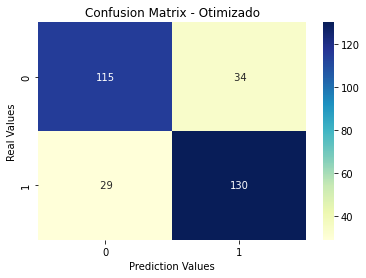

[MODELO ADABOOST CLASSIFIER] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:
Média Acurácia: 81.44%
Média ROC-AUC: 0.87
Média F1-Score: 82.54%
Média Recall: 88.34%


ADABOOST - Feature Importance:
                                       Feature  Importance
68                                 cultEsc_Pos        0.19
55  descoberta_Elucidacao Diagn. em Internacao        0.12
66                            cultEsc_N/realiz        0.11
62                           BACOUTRO_N/realiz        0.10
59                                     bac_Neg        0.08
..                                         ...         ...
34                         tipoCaso_Retr Aband        0.00
31                               sitAtual_Cura        0.00
29               TIPOCUP_Profissional de Saude        0.00
28                               TIPOCUP_Outra        0.00
52       descoberta_Busca Ativa em Instituicao        0.00

[105 rows x 2 columns]


In [85]:
import optuna
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

# Definir a função objetivo para otimização com o Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 30, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
    
    model = AdaBoostClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    accuracy = scores.mean()
    
    return accuracy

# Criar um estudo Optuna e otimizar os hiperparâmetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Obter os melhores hiperparâmetros encontrados
best_params = study.best_params

# Criar o modelo com os melhores hiperparâmetros
best_model = AdaBoostClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Fazer previsões com o modelo otimizado
pred_ada_optimized = best_model.predict(X_test)

# Avaliar o desempenho do modelo otimizado
print('Resultados do modelo otimizado')
print(confusion_matrix(y_test, pred_ada_optimized))
print(classification_report(y_test, pred_ada_optimized))
matriz_confusao_optimized = confusion_matrix(y_test, pred_ada_optimized)
sns.heatmap(matriz_confusao_optimized, cmap='YlGnBu', annot=True, fmt='3')
plt.title('Confusion Matrix - Otimizado')
plt.ylabel('Real Values')
plt.xlabel('Prediction Values')
plt.show()

# Com Cross Validação
adaboost_accuracy = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')
adaboost_roc_auc = cross_val_score(best_model, X_train, y_train, cv=10, scoring='roc_auc')
adaboost_f1 = cross_val_score(best_model, X_train, y_train, cv=10, scoring='f1')
adaboost_recall = cross_val_score(best_model, X_train, y_train, cv=10, scoring='recall')

adaboost_cross_accuracy = np.mean(adaboost_accuracy)
adaboost_cross_roc_auc = np.mean(adaboost_roc_auc)
adaboost_cross_f1 = np.mean(adaboost_f1)
adaboost_cross_recall = np.mean(adaboost_recall)

print('[MODELO ADABOOST CLASSIFIER] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:')
print(f'Média Acurácia: {adaboost_cross_accuracy*100:.2f}%')
print(f'Média ROC-AUC: {adaboost_cross_roc_auc:.2f}')
print(f'Média F1-Score: {adaboost_cross_f1*100:.2f}%')
print(f'Média Recall: {adaboost_cross_recall*100:.2f}%')

# Obter os valores de importância das features
adaboost_importances = best_model.feature_importances_

# Criar um DataFrame com as features e seus valores de importância
adaboost_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': adaboost_importances})

# Ordenar o DataFrame em ordem decrescente de importância
adaboost_feature_importance_df = adaboost_feature_importance_df.sort_values(by='Importance', ascending=False)

# Exibir o DataFrame ordenado
print('\n')
print("ADABOOST - Feature Importance:")
print(adaboost_feature_importance_df)

### Random Forest

[I 2023-08-18 16:54:39,172] A new study created in memory with name: no-name-020b32d1-00d9-4931-ad16-35f6ef4bc767
[I 2023-08-18 16:54:43,228] Trial 0 finished with value: 0.8143409302945488 and parameters: {'n_estimators': 204, 'max_depth': 14}. Best is trial 0 with value: 0.8143409302945488.
[I 2023-08-18 16:54:46,972] Trial 1 finished with value: 0.8167932826869253 and parameters: {'n_estimators': 216, 'max_depth': 7}. Best is trial 1 with value: 0.8167932826869253.
[I 2023-08-18 16:54:51,123] Trial 2 finished with value: 0.8176062908170065 and parameters: {'n_estimators': 262, 'max_depth': 6}. Best is trial 2 with value: 0.8176062908170065.
[I 2023-08-18 16:54:53,061] Trial 3 finished with value: 0.8143475942956151 and parameters: {'n_estimators': 101, 'max_depth': 10}. Best is trial 2 with value: 0.8176062908170065.
[I 2023-08-18 16:54:57,645] Trial 4 finished with value: 0.8143542582966813 and parameters: {'n_estimators': 240, 'max_depth': 5}. Best is trial 2 with value: 0.8176062

Resultados do modelo otimizado
[[115  34]
 [ 28 131]]
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.79       149
         1.0       0.79      0.82      0.81       159

    accuracy                           0.80       308
   macro avg       0.80      0.80      0.80       308
weighted avg       0.80      0.80      0.80       308



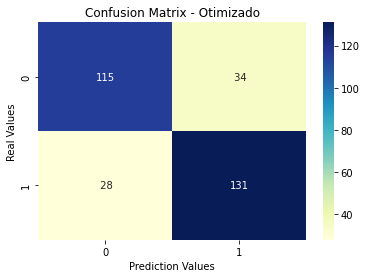

[MODELO RANDOM FOREST CLASSIFIER] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:
Média Acurácia: 81.92%
Média ROC-AUC: 0.87
Média F1-Score: 83.18%
Média Recall: 89.98%


RANDOM FOREST - Feature Importance:
                Feature  Importance
68          cultEsc_Pos    0.287605
66     cultEsc_N/realiz    0.216999
67          cultEsc_Neg    0.040997
92          TABAGISMO_S    0.038407
91          TABAGISMO_N    0.037467
..                  ...         ...
74      NECROP_BAAR pos    0.000037
76  NECROP_Sugestivo TB    0.000000
37   FORMACLIN1_Genital    0.000000
42     FORMACLIN1_Ossea    0.000000
77              hiv_And    0.000000

[105 rows x 2 columns]


In [68]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Definir a função objetivo para otimização com o Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    accuracy = scores.mean()
    
    return accuracy

# Criar um estudo Optuna e otimizar os hiperparâmetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Obter os melhores hiperparâmetros encontrados
best_params = study.best_params

# Criar o modelo com os melhores hiperparâmetros
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Fazer previsões com o modelo otimizado
pred_rf_optimized = best_model.predict(X_test)

# Avaliar o desempenho do modelo otimizado
print('Resultados do modelo otimizado')
print(confusion_matrix(y_test, pred_rf_optimized))
print(classification_report(y_test, pred_rf_optimized))
matriz_confusao_optimized = confusion_matrix(y_test, pred_rf_optimized)
sns.heatmap(matriz_confusao_optimized, cmap='YlGnBu', annot=True, fmt='3')
plt.title('Confusion Matrix - Otimizado')
plt.ylabel('Real Values')
plt.xlabel('Prediction Values')
plt.show()

# Com Cross Validação
rf_accuracy = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')
rf_roc_auc = cross_val_score(best_model, X_train, y_train, cv=10, scoring='roc_auc')
rf_f1 = cross_val_score(best_model, X_train, y_train, cv=10, scoring='f1')
rf_recall = cross_val_score(best_model, X_train, y_train, cv=10, scoring='recall')

rf_cross_accuracy = np.mean(rf_accuracy)
rf_cross_roc_auc = np.mean(rf_roc_auc)
rf_cross_f1 = np.mean(rf_f1)
rf_cross_recall = np.mean(rf_recall)

print('[MODELO RANDOM FOREST CLASSIFIER] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:')
print(f'Média Acurácia: {rf_cross_accuracy*100:.2f}%')
print(f'Média ROC-AUC: {rf_cross_roc_auc:.2f}')
print(f'Média F1-Score: {rf_cross_f1*100:.2f}%')
print(f'Média Recall: {rf_cross_recall*100:.2f}%')

# Obter os valores de importância das features
rf_importances = best_model.feature_importances_

# Criar um DataFrame com as features e seus valores de importância
rf_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_importances})

# Ordenar o DataFrame em ordem decrescente de importância
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)

# Exibir o DataFrame ordenado
print('\n')
print("RANDOM FOREST - Feature Importance:")
print(rf_feature_importance_df)


### SVM

[I 2023-08-09 19:33:44,138] A new study created in memory with name: no-name-656f7e07-56cd-4fbc-8368-8ccc91b99c35


[I 2023-08-09 19:33:46,246] Trial 0 finished with value: 0.7926496068239371 and parameters: {'C': 6.308533144793601, 'kernel': 'poly'}. Best is trial 0 with value: 0.7926496068239371.
[I 2023-08-09 19:33:48,025] Trial 1 finished with value: 0.8342796214847393 and parameters: {'C': 0.7064416282014331, 'kernel': 'rbf'}. Best is trial 1 with value: 0.8342796214847393.
[I 2023-08-09 19:33:49,370] Trial 2 finished with value: 0.8285819005731042 and parameters: {'C': 0.015446480633540665, 'kernel': 'linear'}. Best is trial 1 with value: 0.8342796214847393.
[I 2023-08-09 19:33:50,798] Trial 3 finished with value: 0.8277622284419566 and parameters: {'C': 0.13348108534346687, 'kernel': 'linear'}. Best is trial 1 with value: 0.8342796214847393.
[I 2023-08-09 19:33:53,088] Trial 4 finished with value: 0.7852992136478741 and parameters: {'C': 22.704852616818105, 'kernel': 'rbf'}. Best is trial 1 with value: 0.8342796214847393.
[I 2023-08-09 19:34:04,636] Trial 5 finished with value: 0.822044515527

Resultados do modelo otimizado
[[122  33]
 [ 16 136]]
              precision    recall  f1-score   support

         0.0       0.88      0.79      0.83       155
         1.0       0.80      0.89      0.85       152

    accuracy                           0.84       307
   macro avg       0.84      0.84      0.84       307
weighted avg       0.84      0.84      0.84       307



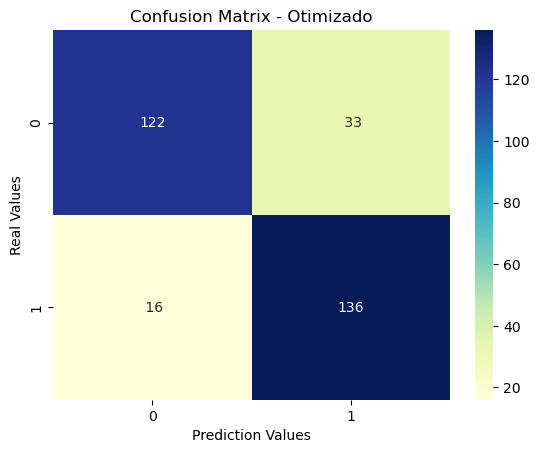

[MODELO SUPPORT VECTOR MACHINE] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:
Média Acurácia: 84.16%
Média ROC-AUC: 0.88
Média F1-Score: 84.96%
Média Recall: 89.25%


In [209]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Definir a função objetivo para otimização com o Optuna
def objective(trial):
    C = trial.suggest_float('C', 0.01, 100, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    
    model = SVC(
        C=C,
        kernel=kernel,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    accuracy = scores.mean()
    
    return accuracy

# Criar um estudo Optuna e otimizar os hiperparâmetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

# Obter os melhores hiperparâmetros encontrados
best_params = study.best_params

# Criar o modelo com os melhores hiperparâmetros
best_model = SVC(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Fazer previsões com o modelo otimizado
pred_svm_optimized = best_model.predict(X_test)

# Avaliar o desempenho do modelo otimizado
print('Resultados do modelo otimizado')
print(confusion_matrix(y_test, pred_svm_optimized))
print(classification_report(y_test, pred_svm_optimized))
matriz_confusao_optimized = confusion_matrix(y_test, pred_svm_optimized)
sns.heatmap(matriz_confusao_optimized, cmap='YlGnBu', annot=True, fmt='3')
plt.title('Confusion Matrix - Otimizado')
plt.ylabel('Real Values')
plt.xlabel('Prediction Values')
plt.show()

# Com Cross Validação
svm_accuracy = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')
svm_roc_auc = cross_val_score(best_model, X_train, y_train, cv=10, scoring='roc_auc')
svm_f1 = cross_val_score(best_model, X_train, y_train, cv=10, scoring='f1')
svm_recall = cross_val_score(best_model, X_train, y_train, cv=10, scoring='recall')

svm_cross_accuracy = np.mean(svm_accuracy)
svm_cross_roc_auc = np.mean(svm_roc_auc)
svm_cross_f1 = np.mean(svm_f1)
svm_cross_recall = np.mean(svm_recall)

print('[MODELO SUPPORT VECTOR MACHINE] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:')
print(f'Média Acurácia: {svm_cross_accuracy*100:.2f}%')
print(f'Média ROC-AUC: {svm_cross_roc_auc:.2f}')
print(f'Média F1-Score: {svm_cross_f1*100:.2f}%')
print(f'Média Recall: {svm_cross_recall*100:.2f}%')

### XGboost

[I 2023-08-09 20:15:45,194] A new study created in memory with name: no-name-bffbb04a-c9ce-4e06-b5f2-70f095a21180


[I 2023-08-09 20:15:49,943] Trial 0 finished with value: 0.8253165400506465 and parameters: {'booster': 'gblinear', 'lambda': 0.10852925277444858, 'alpha': 0.015520331070219048, 'eta': 0.15788732197302188}. Best is trial 0 with value: 0.8253165400506465.
[I 2023-08-09 20:15:54,745] Trial 1 finished with value: 0.8400239904038385 and parameters: {'booster': 'gbtree', 'lambda': 2.3275292269879055e-05, 'alpha': 5.425457322415992, 'eta': 0.8293749659515816}. Best is trial 1 with value: 0.8400239904038385.
[I 2023-08-09 20:15:58,016] Trial 2 finished with value: 0.501219512195122 and parameters: {'booster': 'gblinear', 'lambda': 0.00024526701959869953, 'alpha': 0.7633936671234157, 'eta': 0.7259446414785917}. Best is trial 1 with value: 0.8400239904038385.
[I 2023-08-09 20:16:07,381] Trial 3 finished with value: 0.8228508596561376 and parameters: {'booster': 'gbtree', 'lambda': 0.00742121451249246, 'alpha': 0.013138134157763739, 'eta': 0.10704312979238219}. Best is trial 1 with value: 0.8400

Resultados do modelo otimizado
[[122  33]
 [ 14 138]]
              precision    recall  f1-score   support

         0.0       0.90      0.79      0.84       155
         1.0       0.81      0.91      0.85       152

    accuracy                           0.85       307
   macro avg       0.85      0.85      0.85       307
weighted avg       0.85      0.85      0.85       307



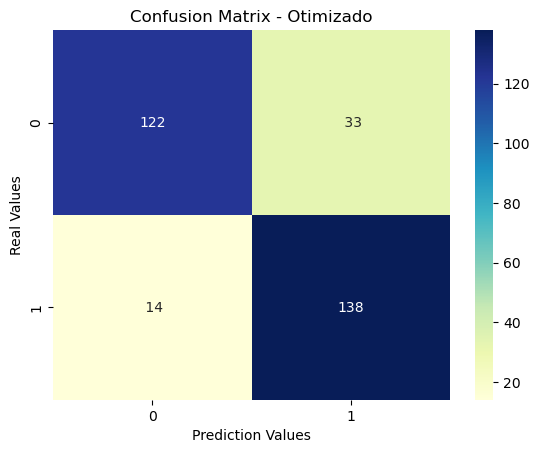

[MODELO XGBOOST] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:
Média Acurácia: 84.65%
Média ROC-AUC: 0.89
Média F1-Score: 85.34%
Média Recall: 89.24%


XGBOOST - Feature Importance:
                                   Feature  Importance
68                             cultEsc_Pos        0.67
62                       BACOUTRO_N/realiz        0.06
90                             TABAGISMO_N        0.02
53   descoberta_Busca Ativa em Instituicao        0.02
60                                 bac_Neg        0.01
..                                     ...         ...
57     descoberta_Investigacao de Contatos        0.00
65                             cultEsc_And        0.00
67                             cultEsc_Neg        0.00
71                      RX_Outra Patologia        0.00
103                HISTOPATOL_Sugestivo TB        0.00

[104 rows x 2 columns]


In [211]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Definir a função objetivo para otimização com o Optuna
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-5, 10, log=True),
        'alpha': trial.suggest_float('alpha', 1e-5, 10, log=True),
        'eta': trial.suggest_float('eta', 0.01, 1.0, log=True),
    }
    
    model = xgb.XGBClassifier(**params, random_state=42)

    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    accuracy = scores.mean()
    
    return accuracy

# Criar um estudo Optuna e otimizar os hiperparâmetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

# Obter os melhores hiperparâmetros encontrados
best_params = study.best_params

# Criar o modelo com os melhores hiperparâmetros
best_model = xgb.XGBClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Fazer previsões com o modelo otimizado
pred_xgb_optimized = best_model.predict(X_test)

# Avaliar o desempenho do modelo otimizado
print('Resultados do modelo otimizado')
print(confusion_matrix(y_test, pred_xgb_optimized))
print(classification_report(y_test, pred_xgb_optimized))
matriz_confusao_optimized = confusion_matrix(y_test, pred_xgb_optimized)
sns.heatmap(matriz_confusao_optimized, cmap='YlGnBu', annot=True, fmt='3')
plt.title('Confusion Matrix - Otimizado')
plt.ylabel('Real Values')
plt.xlabel('Prediction Values')
plt.show()

# Com Cross Validação
xgb_accuracy = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')
xgb_roc_auc = cross_val_score(best_model, X_train, y_train, cv=10, scoring='roc_auc')
xgb_f1 = cross_val_score(best_model, X_train, y_train, cv=10, scoring='f1')
xgb_recall = cross_val_score(best_model, X_train, y_train, cv=10, scoring='recall')

xgb_cross_accuracy = np.mean(xgb_accuracy)
xgb_cross_roc_auc = np.mean(xgb_roc_auc)
xgb_cross_f1 = np.mean(xgb_f1)
xgb_cross_recall = np.mean(xgb_recall)

print('[MODELO XGBOOST] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:')
print(f'Média Acurácia: {xgb_cross_accuracy*100:.2f}%')
print(f'Média ROC-AUC: {xgb_cross_roc_auc:.2f}')
print(f'Média F1-Score: {xgb_cross_f1*100:.2f}%')
print(f'Média Recall: {xgb_cross_recall*100:.2f}%')

# Obter os valores de importância das features
xgb_importances = best_model.feature_importances_

# Criar um DataFrame com as features e seus valores de importância
xgb_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_importances})

# Ordenar o DataFrame em ordem decrescente de importância
xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='Importance', ascending=False)

# Exibir o DataFrame ordenado
print('\n')
print("XGBOOST - Feature Importance:")
print(xgb_feature_importance_df)

### Regressão logística

[I 2023-08-25 12:45:53,569] A new study created in memory with name: no-name-0aac0cbf-c6ad-4314-9dc3-edf98caf2301
[I 2023-08-25 12:45:53,937] Trial 0 finished with value: 0.8012994802079169 and parameters: {'solver': 'liblinear', 'max_iter': 166, 'class_weight': None, 'C': 1.3579377844022922}. Best is trial 0 with value: 0.8012994802079169.
[I 2023-08-25 12:45:54,535] Trial 1 finished with value: 0.8127349060375849 and parameters: {'solver': 'sag', 'max_iter': 288, 'class_weight': 'balanced', 'C': 0.012096529386756793}. Best is trial 1 with value: 0.8127349060375849.
[I 2023-08-25 12:45:54,728] Trial 2 finished with value: 0.8012994802079169 and parameters: {'solver': 'liblinear', 'max_iter': 680, 'class_weight': None, 'C': 1.4661675027116405}. Best is trial 1 with value: 0.8127349060375849.
[I 2023-08-25 12:45:54,920] Trial 3 finished with value: 0.8004864720778355 and parameters: {'solver': 'liblinear', 'max_iter': 202, 'class_weight': None, 'C': 9.267065245287208}. Best is trial 1 w

Resultados do modelo otimizado
[[113  36]
 [ 30 129]]
              precision    recall  f1-score   support

         0.0       0.79      0.76      0.77       149
         1.0       0.78      0.81      0.80       159

    accuracy                           0.79       308
   macro avg       0.79      0.78      0.79       308
weighted avg       0.79      0.79      0.79       308



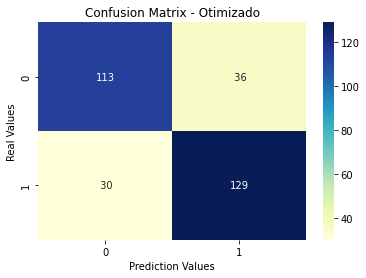

[MODELO REGRESSÃO LOGÍSTICA] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:
Média Acurácia: 81.68%
Média ROC-AUC: 0.87
Média F1-Score: 82.72%
Média Recall: 88.34%


REGRESSÃO LOGÍSTICA - Coeficientes das Features:
                                       Feature  Coefficient
68                                 cultEsc_Pos         1.24
55  descoberta_Elucidacao Diagn. em Internacao         0.32
92                                 TABAGISMO_S         0.29
58                                bac_N/realiz         0.19
90                                DROGADICAO_S         0.15
..                                         ...          ...
62                           BACOUTRO_N/realiz        -0.23
59                                     bac_Neg        -0.27
91                                 TABAGISMO_N        -0.29
67                                 cultEsc_Neg        -0.32
66                            cultEsc_N/realiz        -0.91

[105 rows x 2 columns]


In [90]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Definir a função objetivo para otimização com o Optuna
def objective(trial):
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    C = trial.suggest_float('C', 0.01, 10, log=True)
    
    model = LogisticRegression(
        solver=solver,
        max_iter=max_iter,
        class_weight=class_weight,
        C=C,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    accuracy = scores.mean()
    
    return accuracy

# Criar um estudo Optuna e otimizar os hiperparâmetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Obter os melhores hiperparâmetros encontrados
best_params = study.best_params

# Criar o modelo com os melhores hiperparâmetros
best_model = LogisticRegression(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Fazer previsões com o modelo otimizado
pred_lr_optimized = best_model.predict(X_test)

# Avaliar o desempenho do modelo otimizado
print('Resultados do modelo otimizado')
print(confusion_matrix(y_test, pred_lr_optimized))
print(classification_report(y_test, pred_lr_optimized))
matriz_confusao_optimized = confusion_matrix(y_test, pred_lr_optimized)
sns.heatmap(matriz_confusao_optimized, cmap='YlGnBu', annot=True, fmt='3')
plt.title('Confusion Matrix - Otimizado')
plt.ylabel('Real Values')
plt.xlabel('Prediction Values')
plt.show()

# Com Cross Validação
lr_accuracy = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')
lr_roc_auc = cross_val_score(best_model, X_train, y_train, cv=10, scoring='roc_auc')
lr_f1 = cross_val_score(best_model, X_train, y_train, cv=10, scoring='f1')
lr_recall = cross_val_score(best_model, X_train, y_train, cv=10, scoring='recall')

lr_cross_accuracy = np.mean(lr_accuracy)
lr_cross_roc_auc = np.mean(lr_roc_auc)
lr_cross_f1 = np.mean(lr_f1)
lr_cross_recall = np.mean(lr_recall)

print('[MODELO REGRESSÃO LOGÍSTICA] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:')
print(f'Média Acurácia: {lr_cross_accuracy*100:.2f}%')
print(f'Média ROC-AUC: {lr_cross_roc_auc:.2f}')
print(f'Média F1-Score: {lr_cross_f1*100:.2f}%')
print(f'Média Recall: {lr_cross_recall*100:.2f}%')

# Obter os coeficientes das features da Regressão Logística
lr_coefficients = best_model.coef_[0]

# Criar um DataFrame com as features e seus coeficientes
lr_coefficients_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lr_coefficients})

# Ordenar o DataFrame pelos coeficientes em ordem decrescente
lr_coefficients_df = lr_coefficients_df.sort_values(by='Coefficient', ascending=False)

# Exibir o DataFrame ordenado
print('\n')
print("REGRESSÃO LOGÍSTICA - Coeficientes das Features:")
print(lr_coefficients_df)


### Salvar os resultados dos modelos
* Os resultados são armazenados em uma tabela excel

In [213]:
# Definir os dados das métricas para cada modelo
data = {
    'Modelo': ['Adaboost', 'Random Forest', 'SVM', 'XGBoost', 'Regressão Logística'],
    'Accuracy': [adaboost_cross_accuracy, rf_cross_accuracy, svm_cross_accuracy, xgb_cross_accuracy, lr_cross_accuracy],
    'ROC-AUC': [adaboost_cross_roc_auc, rf_cross_roc_auc, svm_cross_roc_auc, xgb_cross_roc_auc, lr_cross_roc_auc],
    'F1-Score': [adaboost_cross_f1, rf_cross_f1, svm_cross_f1, xgb_cross_f1, lr_cross_f1],
    'Recall': [adaboost_cross_recall, rf_cross_recall, svm_cross_recall, xgb_cross_recall, lr_cross_recall]
}

# Criar um DataFrame com os dados
df_metrics = pd.DataFrame(data)

# Definir o nome do arquivo Excel
excel_filename = '../Results/models_results.xlsx'

# Salvar o DataFrame no arquivo Excel
df_metrics.to_excel(excel_filename, index=False)

print(f"Arquivo '{excel_filename}' criado com sucesso!")

Arquivo '../Results/models_results.xlsx' criado com sucesso!


### Sequential Feature Selector
* Método de seleção de feature

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector

# Criar o seletor de atributos SFS
sfs = SequentialFeatureSelector(model, k_features=10, forward=True, floating=True, verbose=2, scoring='accuracy', cv=5)

# Executar o SFS no conjunto de treinamento
sfs.fit(X_train, y_train)

# Obter os índices dos atributos selecionados
selected_feature_indices = sfs.k_feature_idx_

# Obter os nomes dos atributos selecionados
selected_feature_names = X_train.columns[[selected_feature_indices]]

# Imprimir os atributos selecionados
print("Atributos selecionados:")
print(selected_feature_names)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  2.2min finished

[2023-07-11 23:23:55] Features: 1/10 -- score: 0.787691613842761[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  3.0min finished

[2023-07-11 23:26:54] Features: 2/10 -- score: 0.7990481805438086[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_job

Atributos selecionados:
Index(['cultEsc', 'testesensibilidade', 'nDosesSeg', 'instTrat', 'TOTCOMUNIC',
       'nDosesPri', 'faixaEtaria', 'TABAGISMO', 'sexo', 'idade'],
      dtype='object')


### Shape
* Analisa o grau de importância das features para uma amostra ou para o modelo todo

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


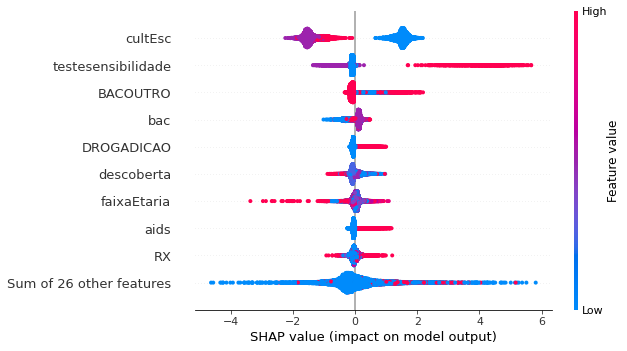

In [150]:
# O Shap não funciona com o Adaboost. Como o XGBoost teve o mesmo desempenho que o Adaboost, vamos usar o XGBoost.
# Usando o shap no conjunto de treino.

import shap

explainer = shap.Explainer(model_xgboost)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

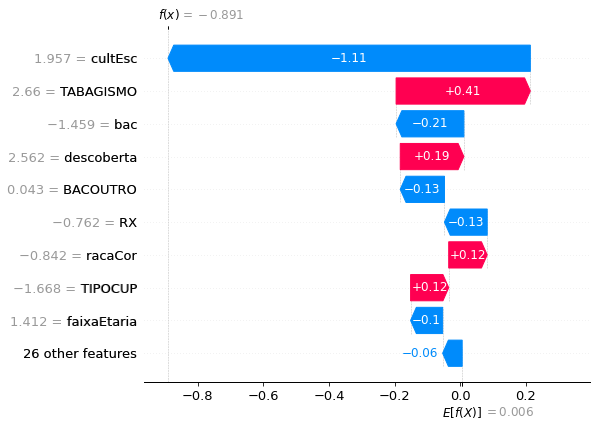

In [151]:
# Shap para um amostra do conjunto de test
explainer = shap.Explainer(model_xgboost)
shap_values = explainer(X_test)

shap.plots.waterfall(shap_values[0])

## Probabilidade de Apresentar Resistência Medicamentosa em cada Cluster

* Uma amostra de pessoas sem resistência medicamentosa em cada cluster

In [86]:
X_test_sem_resistencia_cluster_1 = df_cluster1_normalized[df_cluster1_normalized['Status_Resistencia'] == 0].sample(n=60, random_state=42)
X_test_sem_resistencia_cluster_1 = X_test_sem_resistencia_cluster_1.drop(['Cluster', 'Status_Resistencia'], axis=1)

X_test_sem_resistencia_cluster_2 = df_cluster2_normalized[df_cluster2_normalized['Status_Resistencia'] == 0].sample(n=60, random_state=42)
X_test_sem_resistencia_cluster_2 = X_test_sem_resistencia_cluster_2.drop(['Cluster', 'Status_Resistencia'], axis=1)

X_test_sem_resistencia_cluster_3 = df_cluster3_normalized[df_cluster3_normalized['Status_Resistencia'] == 0].sample(n=60, random_state=42)
X_test_sem_resistencia_cluster_3 = X_test_sem_resistencia_cluster_3.drop(['Cluster', 'Status_Resistencia'], axis=1)

* Aplicar o modelo para prever a probabilidade em cada cluster

In [87]:
# best_model.classes_

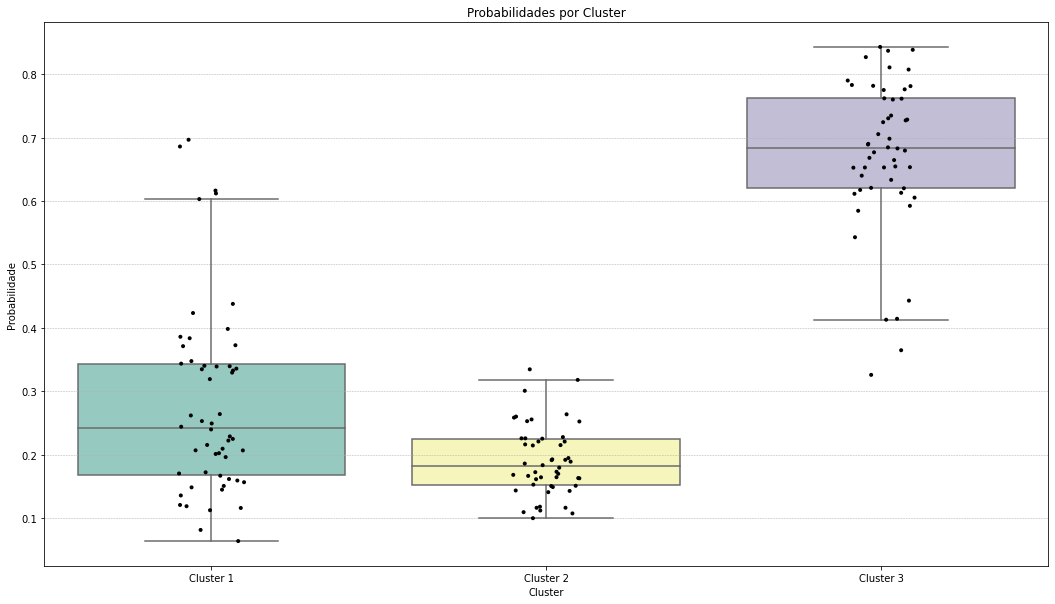

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

prob_1 = best_model.predict_proba(X_test_sem_resistencia_cluster_1)
prob_1 = prob_1[:, 1]

prob_2 = best_model.predict_proba(X_test_sem_resistencia_cluster_2)
prob_2 = prob_2[:, 1]

prob_3 = best_model.predict_proba(X_test_sem_resistencia_cluster_3)
prob_3 = prob_3[:, 1]

# Função para remover outliers
def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

# Remover outliers das variáveis
prob_1 = remove_outliers(prob_1)
prob_2 = remove_outliers(prob_2)
prob_3 = remove_outliers(prob_3)

# Criar um DataFrame para cada vetor
df_prob_1 = pd.DataFrame({'Cluster': ['Cluster 1'] * len(prob_1), 'Probabilidade': prob_1})
df_prob_2 = pd.DataFrame({'Cluster': ['Cluster 2'] * len(prob_2), 'Probabilidade': prob_2})
df_prob_3 = pd.DataFrame({'Cluster': ['Cluster 3'] * len(prob_3), 'Probabilidade': prob_3})

# Concatenar os DataFrames
df_combined = pd.concat([df_prob_1, df_prob_2, df_prob_3], ignore_index=True)

# Criar um gráfico de boxplot usando Seaborn
plt.figure(figsize=(18, 10))
ax = sns.boxplot(data=df_combined, x='Cluster', y='Probabilidade', palette='Set3', showfliers=False)
sns.stripplot(data=df_combined, x='Cluster', y='Probabilidade', color='black', size=4, ax=ax)
plt.title('Probabilidades por Cluster')
plt.ylabel('Probabilidade')

# Adicionar grid no eixo y
ax.yaxis.grid(True, linestyle='--', linewidth=0.5)

plt.show()

## Classificador para Identificar a qual Cluster uma Pessoa Pertence

* Cria o conjunto de teste a partir de uma amostragem estratificada em relação à variável status do paciente. Sendo assim, o conjunto de teste formado mantém a proporção de pacientes com e sem resitência
 - Ex: Supondo que o cluster 1 apresenta uma proporção de 70% com resistência e 30% sem resistência
 - A amostragem estratificada do cluster 1 será um conjunto de teste que tenha 70% com resistência e 30% sem resistência,  mantendo a proporção.

In [497]:
# Vamos utilizar o dataset normalizado

# Inclui a coluna de clusters
df_tuberculosis_normalized['Cluster'] = df_tuberculosis_decode['Cluster']
df_tuberculosis_normalized.head(3)

,cultEsc,testesensibilidade,classif,FORMACLIN1,bac,DROGADICAO,hiv,CULTOUTRO,aids,ALCOOLISMO,...,TABAGISMO,TIPOCUP,sexo,descoberta,mtvInter1,sitAtual,idade,RX,Status_Resistencia,Cluster
0,-1.01,-0.40,-0.41,-0.26,-0.72,-0.42,-0.47,-0.48,-0.35,-0.48,...,-0.36,-1.81,-0.67,-1.31,-1.39,-0.39,-1.33,-0.71,1,2
1,-1.01,1.31,-0.41,-0.26,-0.72,-0.42,-0.47,-0.48,-0.35,-0.48,...,-0.36,-0.84,-0.67,-0.48,-0.72,-0.39,-0.43,0.09,1,0
2,0.15,-0.40,-0.41,-0.26,-0.72,2.39,0.90,-0.48,-0.35,-0.48,...,2.78,-0.84,-0.67,0.35,-0.05,-0.39,0.46,0.09,1,2


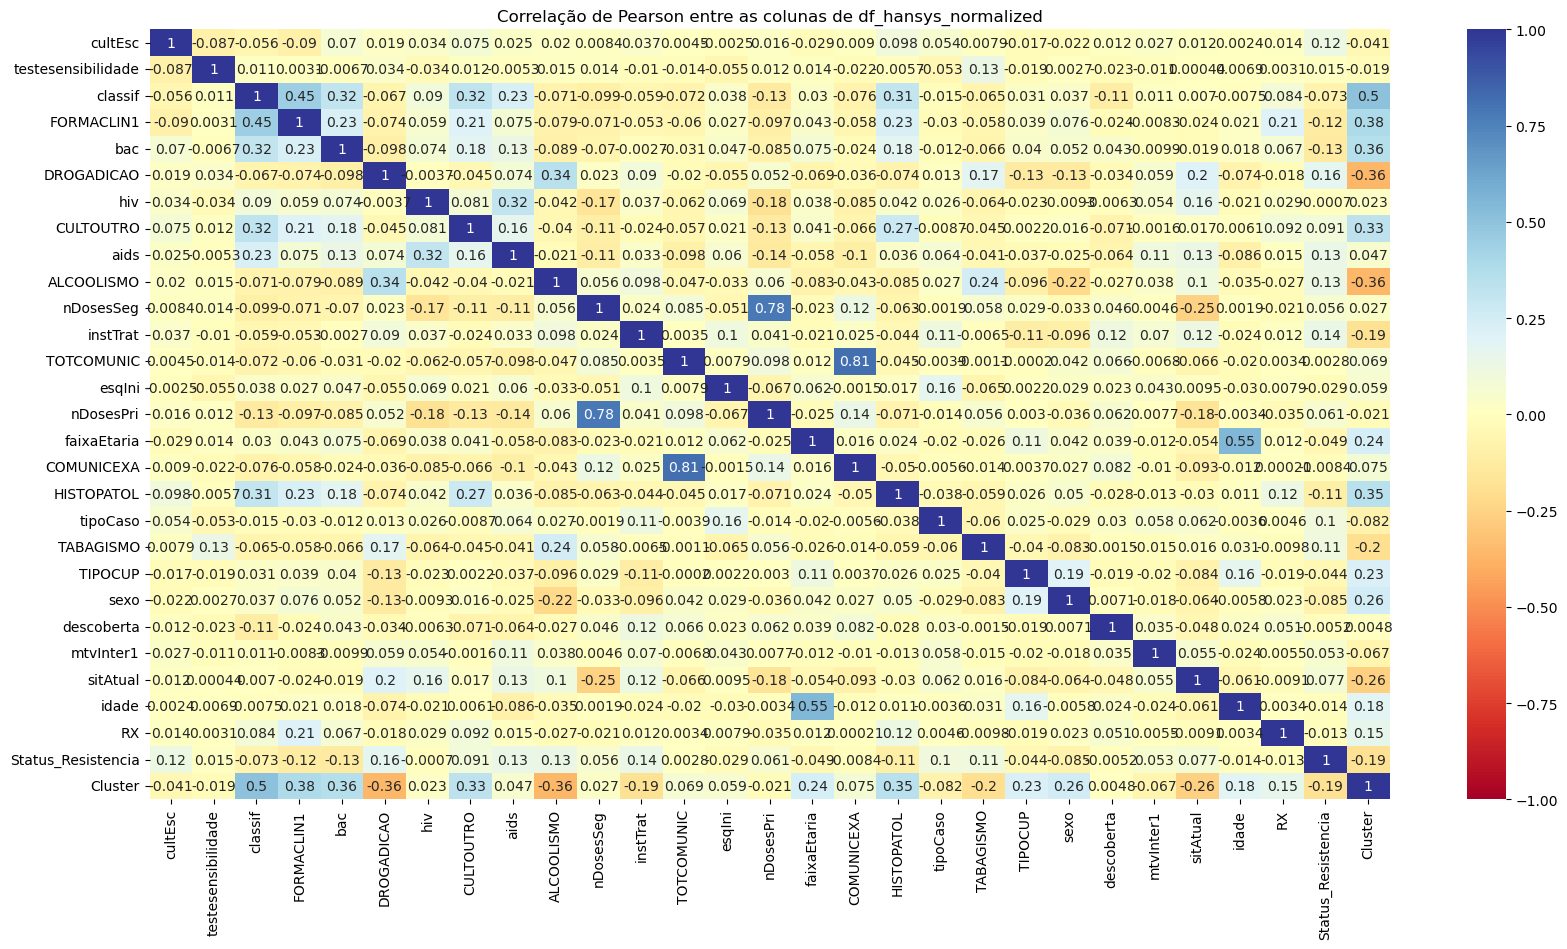

In [ ]:
correlation_matrix = df_tuberculosis_normalized.corr(method='pearson')

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu', vmin=-1, vmax=1)
plt.title('Correlação de Pearson entre as colunas de df_tuberculosis_normalized')
plt.show()

In [ ]:
feature_cluster= df_tuberculosis_normalized.drop(['Status_Resistencia', 'Cluster'], axis=1)
labels_cluster =  df_tuberculosis_normalized['Cluster']
X_train, X_test, y_train, y_test = train_test_split(feature_cluster, labels_cluster,test_size=0.3,stratify=labels_cluster, random_state=42)

In [ ]:
# Analisando a proporção de valores no conjunto de treino
unique_values, counts = np.unique(y_train, return_counts=True)
result = np.column_stack((unique_values, counts)) 
print(result)

[[   0 6632]
 [   1 8639]
 [   2 3358]]


In [ ]:
# Analisando a proporção de valores no conjunto de teste
unique_values, counts = np.unique(y_test, return_counts=True)
result = np.column_stack((unique_values, counts)) 
print(result)

[[   0 2842]
 [   1 3702]
 [   2 1440]]


Valor RN sem Cross Validação
[[2804   28   10]
 [  28 3661   13]
 [   4    4 1432]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2842
           1       0.99      0.99      0.99      3702
           2       0.98      0.99      0.99      1440

    accuracy                           0.99      7984
   macro avg       0.99      0.99      0.99      7984
weighted avg       0.99      0.99      0.99      7984



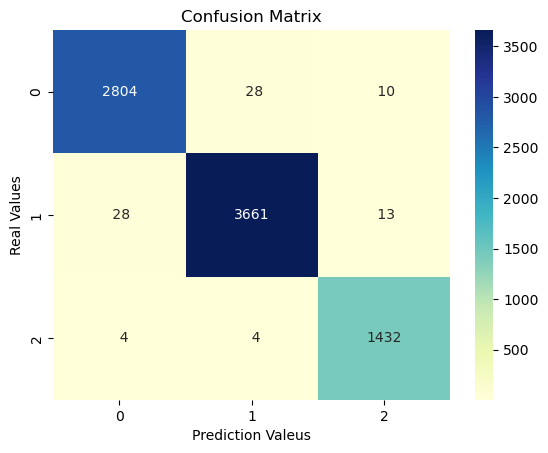

[MODELO LOGISTIC REGRESSION] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:
Média Acurácia: 98.96% 



In [ ]:

model = LogisticRegression()
# Divide em conjunto de treino e validação
# X_train_t, X_val, y_train_t, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# Treina o modulo
model.fit(X_train, y_train)
# Predição no conjunto de validação
pred_log = model.predict(X_test)

# __Matriz de Confusão
print('Valor RN sem Cross Validação')
print(confusion_matrix(y_test, pred_log))
print(classification_report(y_test, pred_log))
matriz_confusão = confusion_matrix(y_test, pred_log)
sns.heatmap(matriz_confusão, cmap='YlGnBu', annot=True, fmt='3')
plt.title('Confusion Matrix')
plt.ylabel('Real Values')
plt.xlabel('Prediction Valeus')

plt.show()

# Com Cross Validação
scores = cross_val_score(
    model, X_train, y_train, cv=10, scoring='accuracy')
mostrar_cross_val = np.mean(scores)
print('[MODELO LOGISTIC REGRESSION] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:')
print(f'Média Acurácia: {mostrar_cross_val*100:.2f}% \n')

In [498]:
# Conjunto de treino e teste para o cluster 1 
df_train1, df_test1 = get_df_train_test(0, df_minib_kmeans)
X_train1, X_test1, y_train1, y_test1 = get_train_test(df_train1, df_test1)

# Conjunto de treino e teste para o cluster 2 
df_train2, df_test2 = get_df_train_test(1, df_minib_kmeans)
X_train2, X_test2, y_train2, y_test2 = get_train_test(df_train2, df_test2)

# Conjunto de treino e teste para o cluster 3 
df_train3, df_test3 = get_df_train_test(2, df_minib_kmeans)
X_train3, X_test3, y_train3, y_test3 = get_train_test(df_train3, df_test3)

In [501]:
# Proporção dos status nos conjuntos de treino e validação
print(f'Proporção do status nos conjuntos de treino e validação:')
print(Counter(y_train1))
print(Counter(y_train2))
print(Counter(y_train3))

Proporção do status nos conjuntos de treino e validação:
Counter({1: 13307, 0: 6224})
Counter({1: 13307, 0: 10264})
Counter({1: 13307, 0: 10126})


[[ 946  271]
 [ 292 2398]]
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1217
           1       0.90      0.89      0.89      2690

    accuracy                           0.86      3907
   macro avg       0.83      0.83      0.83      3907
weighted avg       0.86      0.86      0.86      3907



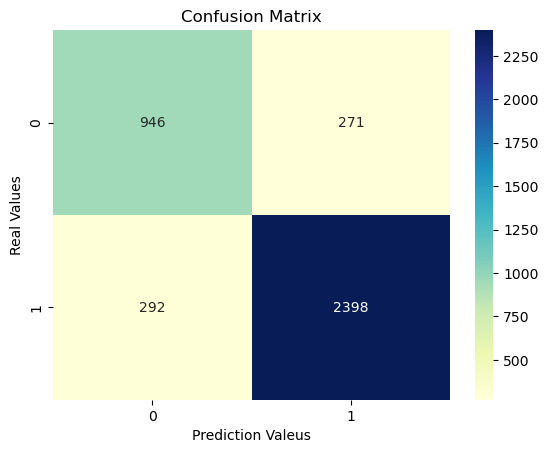

[MODELO LOGISTIC REGRESSION] Média Roc-Auc dos 10 modelos com Cross Validação da base Treinamento:
Média ROC-AU: 89.93% 

[MODELO LOGISTIC REGRESSION] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:
Média Acurácia: 84.74% 

[MODELO LOGISTIC REGRESSION] Média de F1-Score dos 10 modelos com Cross Validação da base Treinamento:
 Média F1-Score: 88.79% 



In [502]:
# Modelo Adaboost para classificar

from sklearn.ensemble import AdaBoostClassifier

model1 = get_cross_val(X_train1, y_train1, 'adaboost')

# # Obter os valores de importância das features
# importances = model1.feature_importances_

# # Criar um DataFrame com as features e seus valores de importância
# feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# # Ordenar o DataFrame em ordem decrescente de importância
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# # Exibir o DataFrame ordenado
# print("Feature Importance:")
# print(feature_importance_df)


[[1611  459]
 [ 397 2248]]
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2070
           1       0.83      0.85      0.84      2645

    accuracy                           0.82      4715
   macro avg       0.82      0.81      0.82      4715
weighted avg       0.82      0.82      0.82      4715



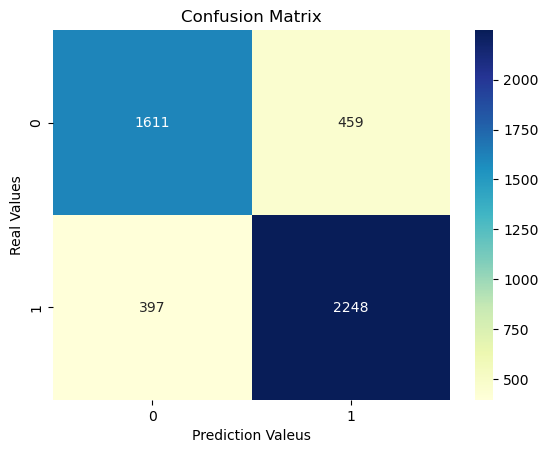

[MODELO LOGISTIC REGRESSION] Média Roc-Auc dos 10 modelos com Cross Validação da base Treinamento:
Média ROC-AU: 86.98% 

[MODELO LOGISTIC REGRESSION] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:
Média Acurácia: 81.17% 

[MODELO LOGISTIC REGRESSION] Média de F1-Score dos 10 modelos com Cross Validação da base Treinamento:
 Média F1-Score: 83.47% 



In [503]:
# Modelo Adaboost para classificar

from sklearn.ensemble import AdaBoostClassifier

model2 = get_cross_val(X_train2, y_train2, 'adaboost')

# # Obter os valores de importância das features
# importances = model1.feature_importances_

# # Criar um DataFrame com as features e seus valores de importância
# feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# # Ordenar o DataFrame em ordem decrescente de importância
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# # Exibir o DataFrame ordenado
# print("Feature Importance:")
# print(feature_importance_df)


[[1634  376]
 [ 396 2281]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      2010
           1       0.86      0.85      0.86      2677

    accuracy                           0.84      4687
   macro avg       0.83      0.83      0.83      4687
weighted avg       0.84      0.84      0.84      4687



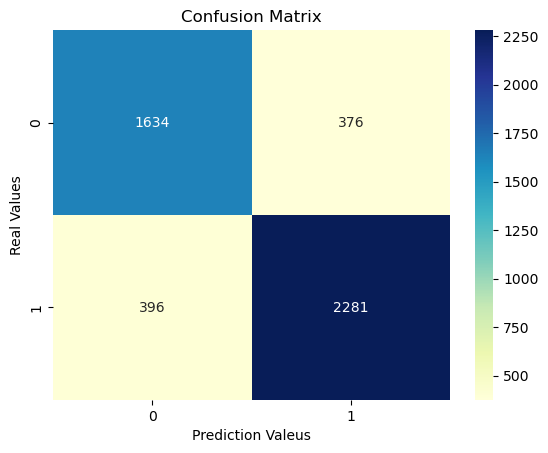

[MODELO LOGISTIC REGRESSION] Média Roc-Auc dos 10 modelos com Cross Validação da base Treinamento:
Média ROC-AU: 90.25% 

[MODELO LOGISTIC REGRESSION] Média de Acurácia dos 10 modelos com Cross Validação da base Treinamento:
Média Acurácia: 83.73% 

[MODELO LOGISTIC REGRESSION] Média de F1-Score dos 10 modelos com Cross Validação da base Treinamento:
 Média F1-Score: 85.71% 



In [505]:
# Modelo Adaboost para classificar

from sklearn.ensemble import AdaBoostClassifier

model3 = get_cross_val(X_train3, y_train3, 'adaboost')

# # Obter os valores de importância das features
# importances = model1.feature_importances_

# # Criar um DataFrame com as features e seus valores de importância
# feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# # Ordenar o DataFrame em ordem decrescente de importância
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# # Exibir o DataFrame ordenado
# print("Feature Importance:")
# print(feature_importance_df)


In [510]:
# Dicionário que armaze todos os modelos de regressão logística
dict_model = {}
dict_model[0] = model1
dict_model[1] = model2
dict_model[2] = model3
# dict_logmodel[3] = logmodel4
# dict_logmodel[4] = logmodel5
# dict_logmodel[5] = logmodel6
# dict_logmodel[6] = logmodel7
# # dict_logmodel[7] = logmodel8

# Dicionário que armazena o conjunto (X_test) de pessoas sem diagnóstico de cada cluster
dict_X_test = {}
dict_X_test[0] = X_test1
dict_X_test[1] = X_test2
dict_X_test[2] = X_test3
# dict_X_test[3] = X_test4
# dict_X_test[4] = X_test5
# dict_X_test[5] = X_test6
# dict_X_test[6] = X_test7
# dict_X_test[7] = X_test8

# Dicionário que armazena a probabilidade das pessoas sem diagnóstico terem a doença para cada cluster
dict_pred_prob = {}

for i in range(quantidade_clusters_minib):
    X_test_exception = dict_X_test[i]
    if X_test_exception.shape[0] == 0:
        dict_pred_prob[i] = []

        print(f'ATENÇÃO: Um dos Clusters possui 100% de pessoas com diagnóstico. Portanto, não há pessoas sem diagnóstico para serem analisadas nesse cluster')
        print(f'Pessoas sem diagnóstico nos clusters:')

        for i in range(quantidade_clusters_minib):
            X_test = dict_X_test[i].shape[0]
            print(f'    Cluster {i+1}: {X_test} pessoas')
    else:
        pred_prob = model_predict_proba(dict_X_test[i], dict_model[i])
        dict_pred_prob[i] = pred_prob

In [511]:
# Dataframe que armazena a probabilidade das pessoas sem diagnóstico terem a doença para cada cluster

df_probabilidade = pd.DataFrame(columns=['Cluster 1', 'Cluster 2', 'Cluster 3'])
aux = np.arange(0, (len(df_minib_kmeans)+1))
df_probabilidade['auxiliar'] = aux
for i in range(len(dict_pred_prob[0])):
    pred_prob1 = dict_pred_prob[0]
    df_probabilidade.loc[df_probabilidade.auxiliar == i, 'Cluster 1'] = pred_prob1[i]

for i in range(len(dict_pred_prob[1])):
    pred_prob2 = dict_pred_prob[1]
    df_probabilidade.loc[df_probabilidade.auxiliar == i, 'Cluster 2'] = pred_prob2[i]

for i in range(len(dict_pred_prob[2])):
    pred_prob3 = dict_pred_prob[2]
    df_probabilidade.loc[df_probabilidade.auxiliar == i, 'Cluster 3'] = pred_prob3[i]

# for i in range(len(dict_pred_prob[3])):
#     pred_prob4 = dict_pred_prob[3]
#     df_probabilidade.loc[df_probabilidade.auxiliar == i, 'Cluster 4'] = pred_prob4[i]

# for i in range(len(dict_pred_prob[4])):
#     pred_prob5 = dict_pred_prob[4]
#     df_probabilidade.loc[df_probabilidade.auxiliar == i, 'Cluster 5'] = pred_prob5[i]

# for i in range(len(dict_pred_prob[5])):
#     pred_prob6 = dict_pred_prob[5]
#     df_probabilidade.loc[df_probabilidade.auxiliar == i, 'Cluster 6'] = pred_prob6[i]

# for i in range(len(dict_pred_prob[6])):
#     pred_prob7 = dict_pred_prob[6]
#     df_probabilidade.loc[df_probabilidade.auxiliar == i, 'Cluster 7'] = pred_prob7[i]

# for i in range(len(dict_pred_prob[7])):
#     pred_prob8 = dict_pred_prob[7]
#     df_probabilidade.loc[df_probabilidade.auxiliar == i, 'Cluster 8'] = pred_prob8[i]

df_probabilidade =  df_probabilidade.drop(['auxiliar'], axis=1)


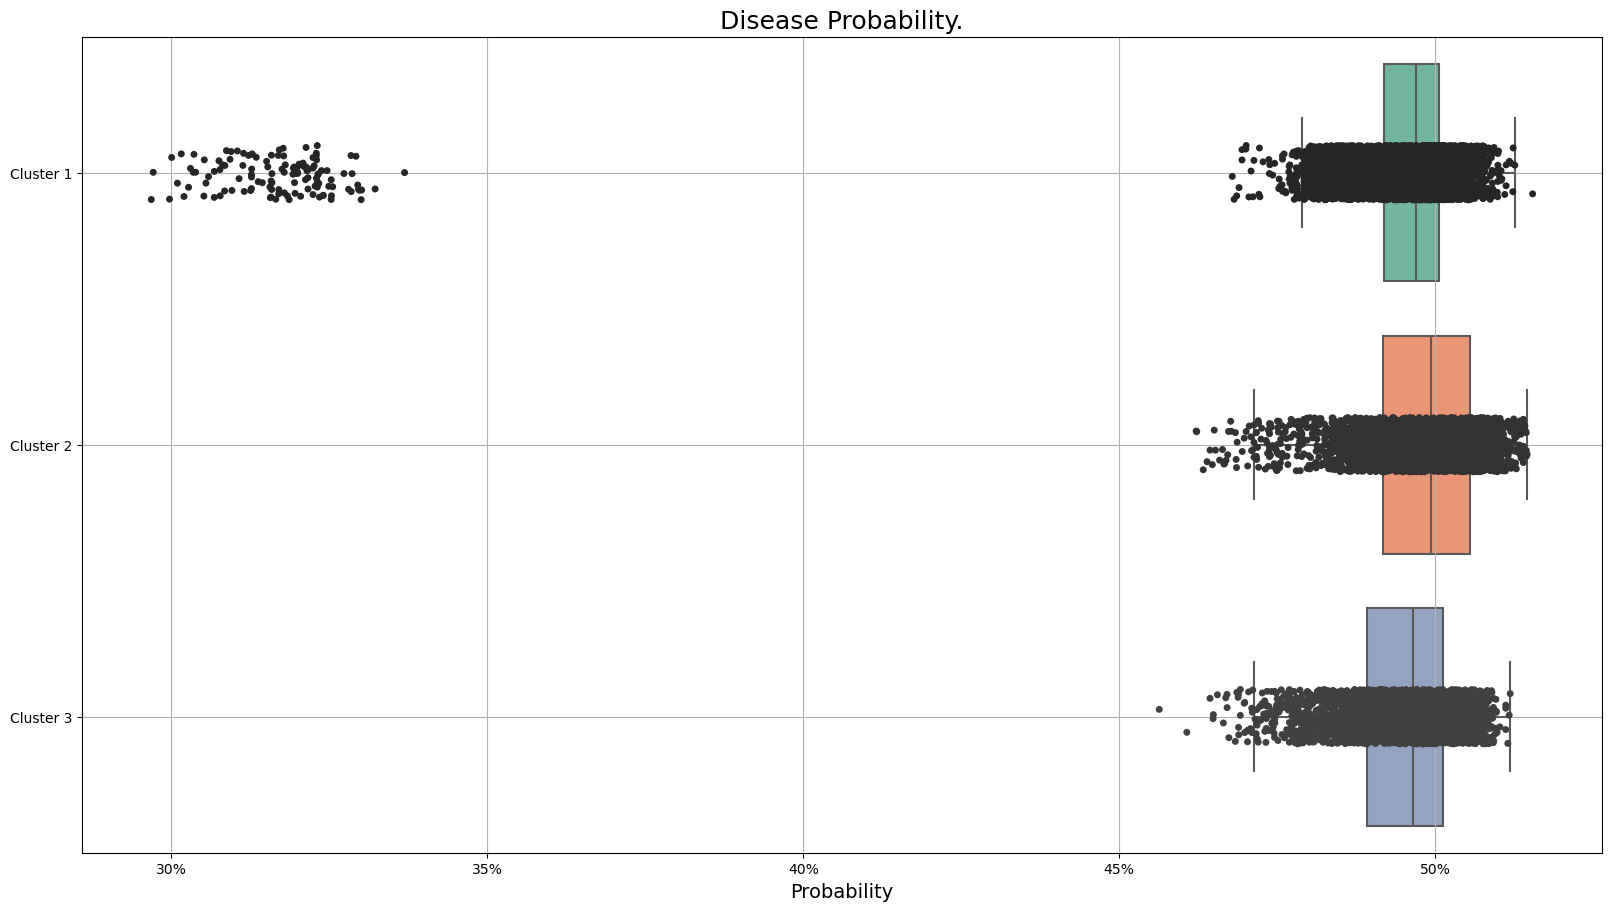

In [512]:
# Gráfico com a distribuição de probabilidades das pessoas sem diagnóstico em cada cluster

fig, ax = plt.subplots(figsize=(16, 9), layout='constrained')

# Tamnho em pt dos eixos
fonte_eixos = {'fontsize': 14}

# Definindo o rótulo para o eixo x
ax.set_xlabel('Probability', fontdict=fonte_eixos)
# Formata eixo x para colocar símbolo de porcentagem
ax.xaxis.set_major_formatter('{x:1.0f}%')
grafico = sns.boxplot(data=df_probabilidade, orient="h", palette="Set2", ax=ax, showfliers = False)

# Adiciona um título para a região de plotagem (ax)
fonte_titulo = {'fontsize': 18}
ax.set_title("Disease Probability.", fontdict=fonte_titulo)


ax = sns.stripplot(data=df_probabilidade, orient="h", ax=ax, color=".25")
ax.grid(True); 

In [513]:
cluster_analisado = pred_prob1
print(cluster_analisado)
max_value = max(cluster_analisado)
print(max_value)
indice = np.where(cluster_analisado == max_value)
print(indice)
# print(cluster_analisado[0])

[49.27606174 49.83574436 50.15429555 ... 49.70489986 50.1904824
 49.76919822]
51.54283530658418
(array([759], dtype=int64),)


In [ ]:
indice2 = np.where(cluster_analisado == cluster_analisado[0])
print(indice2)
print(cluster_analisado[0])

(array([ 0,  3,  7, 20, 23, 25, 30, 33, 34, 35, 43, 47, 49], dtype=int64),)
35.43350813861762


In [ ]:
df_test1.iloc[27]

Número de Lesões        0
Tipo do Paciente        3
Classificação           0
Forma Clinica           0
Contato Positivo        1
Idade                   3
Baciloscopia            0
Grau de Incapacidade    1
Status de Novo Caso     2
Gênero do Paciente      1
Marca da BCG            0
Tratamento              0
Cluster                 0
Name: 293, dtype: int64

In [ ]:
# Unindo as pessoas que não tem o diagnóstico e que serão utilizadas no conjunto de teste para prever a probabilidade de ter a doença
df_sem_diagnostico = pd.concat([df_test1, df_test2, df_test3, df_test4, df_test5, df_test6, df_test7])

# Dataframe com as features mais frequentes das pessoas sem diagnóstico em cada cluster
df_analysis_sem_diagnostico = cluster_analysis_sem_diagnostico(quantidade_clusters_minib, df_sem_diagnostico)
df_analysis_sem_diagnostico



ANÁLISE DOS CLUSTERS SOMENTE DAS PESSOAS SEM DIAGNÓSTICO:

Cluster 0: 50 amostras
Cluster 1: 12 amostras
Cluster 2: 50 amostras
Cluster 3: 0 amostras
Cluster 4: 4 amostras
Cluster 5: 7 amostras
Cluster 6: 23 amostras


,Número de Lesões,Tipo do Paciente,Classificação,Forma Clinica,Contato Positivo,Idade,Baciloscopia,Grau de Incapacidade,Status de Novo Caso,Gênero do Paciente,Marca da BCG,Tratamento
Cluster,,,,,,,,,,,,
Cluster 1,0.0,3.0,0.0,0.0,0.0,3.0,0.0,1.0,2.0,1.0,0.0,0.0
Cluster 2,0.0,3.0,2.0,5.0,0.0,4.0,0.0,1.0,2.0,1.0,0.0,0.0
Cluster 3,0.0,3.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0,1.0,0.0,0.0
Cluster 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster 5,0.0,3.0,2.0,5.0,0.0,4.0,1.0,1.0,2.0,2.0,0.0,3.0
Cluster 6,0.0,3.0,2.0,2.0,0.0,3.0,0.0,1.0,2.0,2.0,0.0,0.0
Cluster 7,0.0,4.0,2.0,5.0,0.0,1.0,0.0,1.0,2.0,1.0,2.0,0.0


## Probabilidade de Peterncer a um cluster

* Para definir o grupo de maior risco é necessário analisar o gráfico com as probabilidades. Para esse execução foi o cluster quatro (df_test4). Caso seja outro cluster basta substituir df_test4 pelo dataframe correspondente

In [ ]:
# # Cluster de maior risco
# print(f'Cluster de maior risco: \n{df_test4.drop(["Tipo do Paciente" ,"Status_Resistencia", "Cluster"], axis=1)}')

#indices das pessoas do cluster de maior risco
cluster_indices = df_test4.index
print(f'\nIndices do dataframe de maior risco: \n{cluster_indices}')

# Quantidade de indices (igual ao número de pessoas do cluster)
number_of_indices = len(cluster_indices)
print(f'\nQuantidade de indices: \n{number_of_indices}')

# Retira as features que não foram utilizadas no treinamento do modelo
df_highest_risk_group = df_cluster.drop(["Status_Resistencia"], axis=1)

# número aleatório de 0 a number_of_indices
random_number = np.random.randint(number_of_indices)

# Seleciona um indice na lista de indices referentes ao cluster de maior risco 
indice_of_the_person_in_the_highest_risk_group = cluster_indices[random_number]
print(f'\nIndice selecionado: \n{indice_of_the_person_in_the_highest_risk_group}')

# seleciona a amostra pelo indice
person_in_the_highest_risk_group = df_highest_risk_group.iloc[[indice_of_the_person_in_the_highest_risk_group]].values
print(f'\nFeatures da pessoa selecionada: \n{person_in_the_highest_risk_group}')



Indices do dataframe de maior risco: 
Int64Index([], dtype='int64')

Quantidade de indices: 
0


ValueError: high <= 0

- A pessoa selecionada do grupo de maior risco não deve estar no dataset de treinamento do novo modelo. Portanto é necessáro retirá-la

In [ ]:
# Novo dataframe para treinar e prever a qual cluster/grupo a pessoa pertence
df_to_calculate_probability_of_belonging_to_a_group = df_minib_kmeans.copy()
df_to_calculate_probability_of_belonging_to_a_group = df_to_calculate_probability_of_belonging_to_a_group.drop(["Status_Resistencia"], axis=1)

# Identifica a linha no dataframe correspondente ao indice da pessoa que pertence ao grupo de maior risco
aux = df_to_calculate_probability_of_belonging_to_a_group.index[[indice_of_the_person_in_the_highest_risk_group]]
print(f'Indice da pessoa no grupo de maior risco: \n{aux}\n')

# Retira a pessoa selecionada do grupo de maior risco
df_to_calculate_probability_of_belonging_to_a_group = df_to_calculate_probability_of_belonging_to_a_group.drop(aux)

print(f'Dataframe após a retirada da pessoa que pertence ao grupo de maior risco: \n')
df_to_calculate_probability_of_belonging_to_a_group

Indice da pessoa no grupo de maior risco: 
Int64Index([848], dtype='int64')

Dataframe após a retirada da pessoa que pertence ao grupo de maior risco: 



,Número de Lesões,Classificação,Forma Clinica,Contato Positivo,Idade,Baciloscopia,Grau de Incapacidade,Gênero do Paciente,Marca da BCG,Tratamento,Cluster
0,0,2,1,0,3,0,0,1,0,0,3
1,0,0,0,0,2,0,1,1,3,0,0
2,2,2,5,0,1,0,1,1,2,0,1
3,1,2,5,0,1,0,2,1,0,0,1
4,0,2,5,0,2,0,1,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...
893,0,0,0,1,4,0,1,2,0,0,4
894,0,0,0,4,3,0,1,2,0,0,4
895,1,2,6,0,2,0,1,2,0,0,1
896,0,0,0,0,0,0,1,2,0,0,0


In [ ]:
# Features do novo modelo
cluster_features = df_to_calculate_probability_of_belonging_to_a_group.drop(["Cluster"], axis=1).values

# Rótulos que agora indicam a qual cluster a pessoa pertence
cluster_labels = df_to_calculate_probability_of_belonging_to_a_group["Cluster"].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cluster_features, cluster_labels, test_size=0.2, random_state=2)

In [ ]:
logmodel = LogisticRegression(max_iter=300)
logmodel.fit(X_train, y_train)

c:\Users\albert.DESKTOP-015ON1O\miniconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300)

In [ ]:
predictions = logmodel.predict(X_test)

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        37
           1       0.97      1.00      0.99        39
           2       1.00      1.00      1.00        17
           3       1.00      0.94      0.97        18
           4       0.96      0.96      0.96        28
           5       0.97      0.97      0.97        31
           6       1.00      0.90      0.95        10

    accuracy                           0.98       180
   macro avg       0.98      0.97      0.97       180
weighted avg       0.98      0.98      0.98       180



In [ ]:
print(confusion_matrix(y_test, predictions))

[[37  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  0]
 [ 0  0 17  0  0  0  0]
 [ 0  0  0 17  0  1  0]
 [ 1  0  0  0 27  0  0]
 [ 0  1  0  0  0 30  0]
 [ 0  0  0  0  1  0  9]]


- Previsões da probabilidade da pessoa do grupo de maior risco

In [ ]:
prediction_prob_person_in_the_highest_risk_group =  logmodel.predict_proba(person_in_the_highest_risk_group)
print(f'Probabilidades da pessoa do grupo de maior risco pertencer a cada um dos clusters: \n{prediction_prob_person_in_the_highest_risk_group}\n')

predict_person_in_the_highest_risk_group =  logmodel.predict(person_in_the_highest_risk_group)
print(f'Previsão do cluster a qual a pessoa do grupo de maior riso pertence: \n{predict_person_in_the_highest_risk_group}\n')

Probabilidades da pessoa do grupo de maior risco pertencer a cada um dos clusters: 
[[5.97052272e-03 3.46488591e-04 7.51650350e-07 9.88328619e-01
  2.80302653e-06 5.15521918e-03 1.95596111e-04]]

Previsão do cluster a qual a pessoa do grupo de maior riso pertence: 
[3]



In [ ]:
print(f'Quantidade de amostras de cada cluster: ')
df_to_calculate_probability_of_belonging_to_a_group["Cluster"].value_counts()

Quantidade de amostras de cada cluster: 


1    189
0    187
5    174
4    144
3     90
2     80
6     33
Name: Cluster, dtype: int64

In [ ]:
# print('--------------------------------------')

# indices_series = df_minib_kmeans_sem_diag4.index
# print(indices_series)

# indices = [0, 2, 3, 4]
# rows_dropped_df= df_cluster.drop(df_cluster.index[indices_series])

# print(rows_dropped_df.shape)
# # print(rows_dropped_df.head())
# # print(df_cluster.shape)
# # print(rows_dropped_df.shape)
# print(type(df_cluster.loc[113]))
# # print(df_minib_kmeans_sem_diag4.index) # converter de pandas series para lista

# # print(df_minib_kmeans_sem_diag4)
# # cluster = df_minib_kmeans_sem_diag4['Status_Resistencia'].isin([2])
# # print(cluster)
# # print(type(cluster))
# # print(cluster.shape)

In [ ]:
# Organizando os dataframes

# Retira a coluna Status do paciente já que essa feature será a saída (label)
features = df_tuberculosis_normalized.drop(['Status_Resistencia'], axis=1)

# Saída com o status dos pacientes será utilizada nos modelos preditivos
labels = df_tuberculosis_normalized['Status_Resistencia'].values

# Gera um dataframe onde será adicionada uma coluna ('Cluster') que indicará a qual cluster cada pessoa pertence
df_cluster = df_tuberculosis_normalized.copy()